In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import hdbscan

## Setup training/test data

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train_l), (x_test, y_test_l) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train_l, num_classes)
y_test = keras.utils.to_categorical(y_test_l, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Load pretrained model

In [7]:
model_save_name = 'mnist_classifier'
path = F"{model_save_name}" 
#model.save(path)
model = keras.models.load_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

## Compute network activations for each image

In [8]:
def getActivationModel(model, layers = model.layers[:]):
    """ Returns a model outputing the activations of each layer, i.e., their outputs """ 
    layer_outputs = [layer.output for layer in layers] # Extracts the outputs of the top layers
    return models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

from keras import models


In [9]:
activations = activation_model.predict(x_test) # Returns a list of Numpy arrays: one array per layer activation


In [10]:
print(len(activations))

7


In [11]:
first_layer_activation = activations[0]
for layer in activations:
  print(layer.shape)

(10000, 26, 26, 32)
(10000, 13, 13, 32)
(10000, 11, 11, 64)
(10000, 5, 5, 64)
(10000, 1600)
(10000, 1600)
(10000, 10)


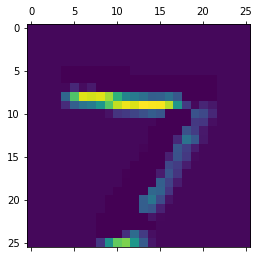

In [12]:

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')


Visualizing every channel in every intermediate activation

C:\Users\danjo\AppData\Local\Temp\ipykernel_15076\3381583659.py:18: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

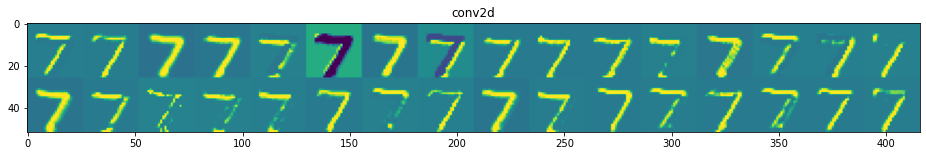

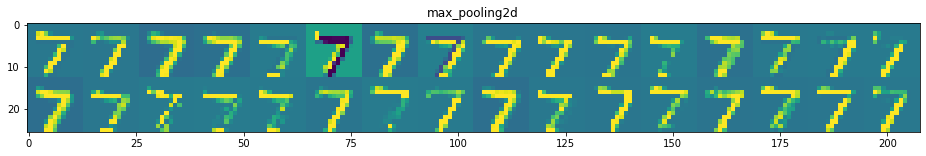

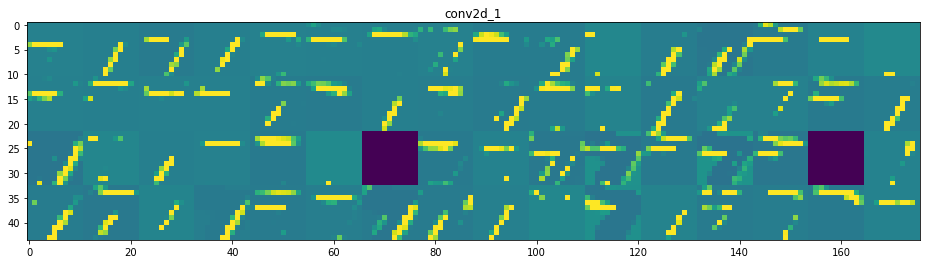

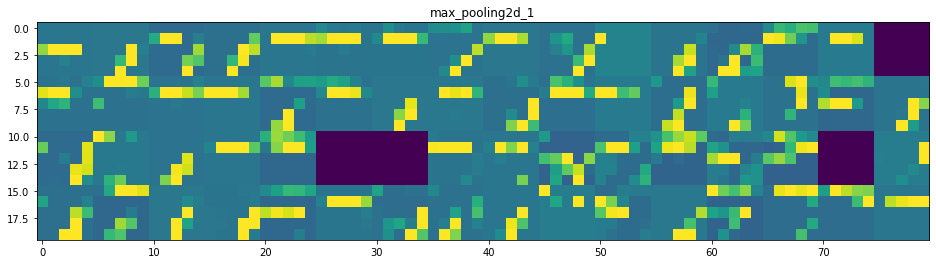

In [9]:

layer_names = []
for layer in model.layers[:]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [13]:
import numpy as np
clusterOnLayer = 5
layer_activations = activations[clusterOnLayer]
layer_feature_max_activations = []
for layer_activation in layer_activations:
  max_activations = [np.mean(layer_activation[:, :,feature].flatten()) for feature in range(layer_activation.shape[-1])]
  layer_feature_max_activations.append(max_activations)

#flattened_activations = [activation.flatten() for activation in activations[clusterOnLayer]] 
print(F"Number of features: {len(layer_feature_max_activations[0])}")

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [50]:
print(F"Number of images: {len(layer_feature_max_activations)}")
#print(len(flattened_activations))
clusterer = hdbscan.HDBSCAN()
clusterer.fit(layer_feature_max_activations)
print(F"Number of clusters: {clusterer.labels_.max() + 1}")



Number of images: 10000
Number of clusters: 52


In [43]:
import pandas as pd
import plotly.express as px
activations_df = {'input_data': [], 'layer': [], 'feature': [], 'activation':[]}
for dp in range(len(layer_feature_max_activations)):
  for feature in range(len(layer_feature_max_activations[0])):
      for activation in layer_feature_max_activations[:][feature]:
        activations_df['input_data'].append(dp)
        activations_df['layer'].append(clusterOnLayer)
        activations_df['feature'].append(feature)
        activations_df['activation'].append(activation)

activations_df = pd.DataFrame(activations_df)

In [ ]:
px.scatter(activations_df, x='feature', y='activation')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [51]:
dd = pd.DataFrame({'cluster': clusterer.labels_, 'label': y_test_l})
# HDBSCAN is noise aware – it has a notion of data samples that are not assigned to any cluster. This is handled by assigning these samples the label -1. 
px.histogram(dd, x='label', facet_row='cluster', title= 'Layer {}: {}'.format(clusterOnLayer, model.layers[clusterOnLayer].name),
height = 2000,
facet_row_spacing=0.005000).update_yaxes(matches=None)


In [52]:
clusters = pd.DataFrame({"clusterId": clusterer.labels_})

In [53]:
#x_test[0].shape


Cluster  -1, size: 7529


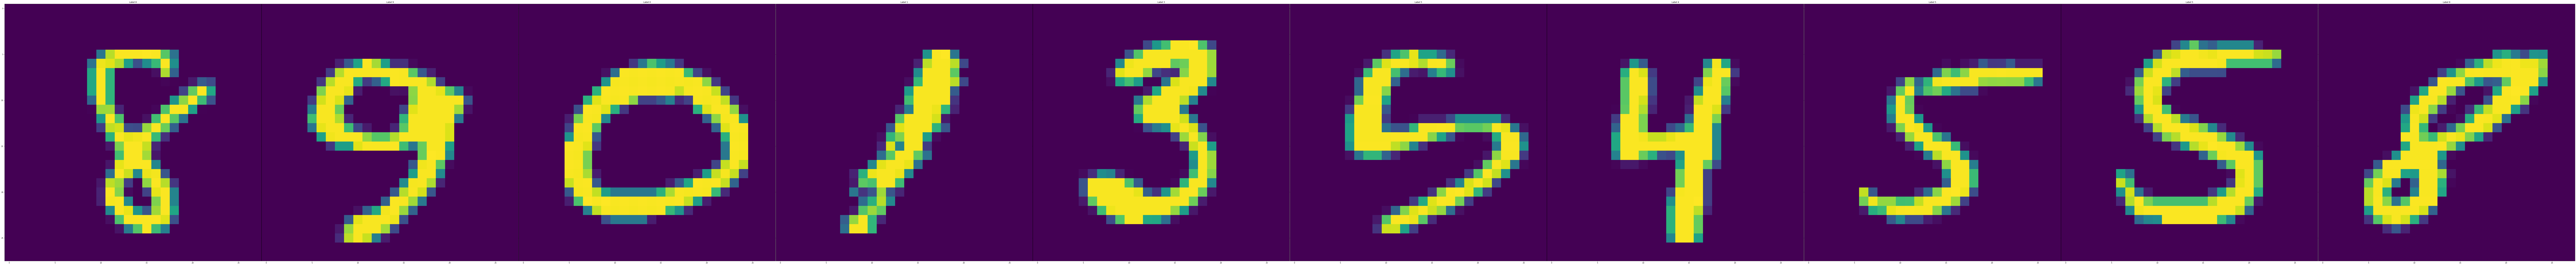

Cluster  43, size: 1028


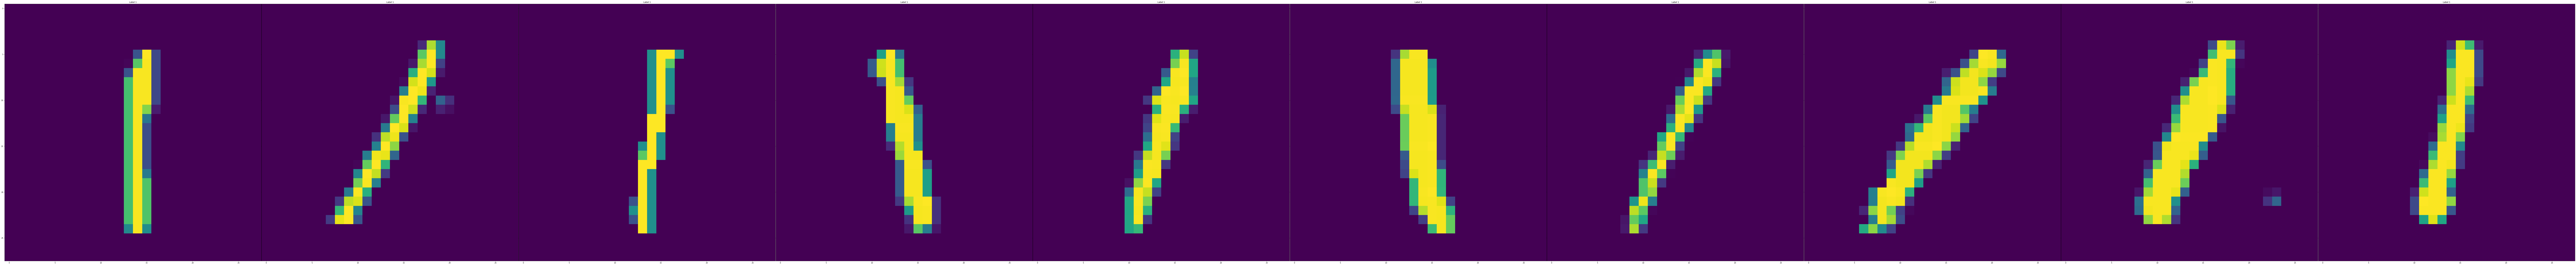

Cluster  49, size: 48


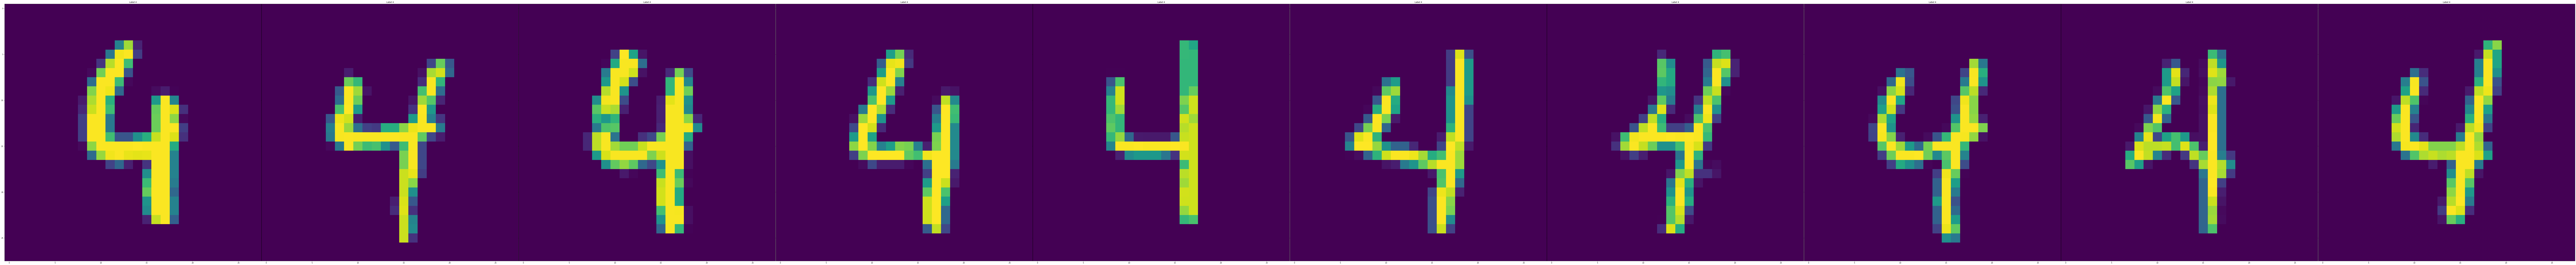

Cluster  47, size: 299


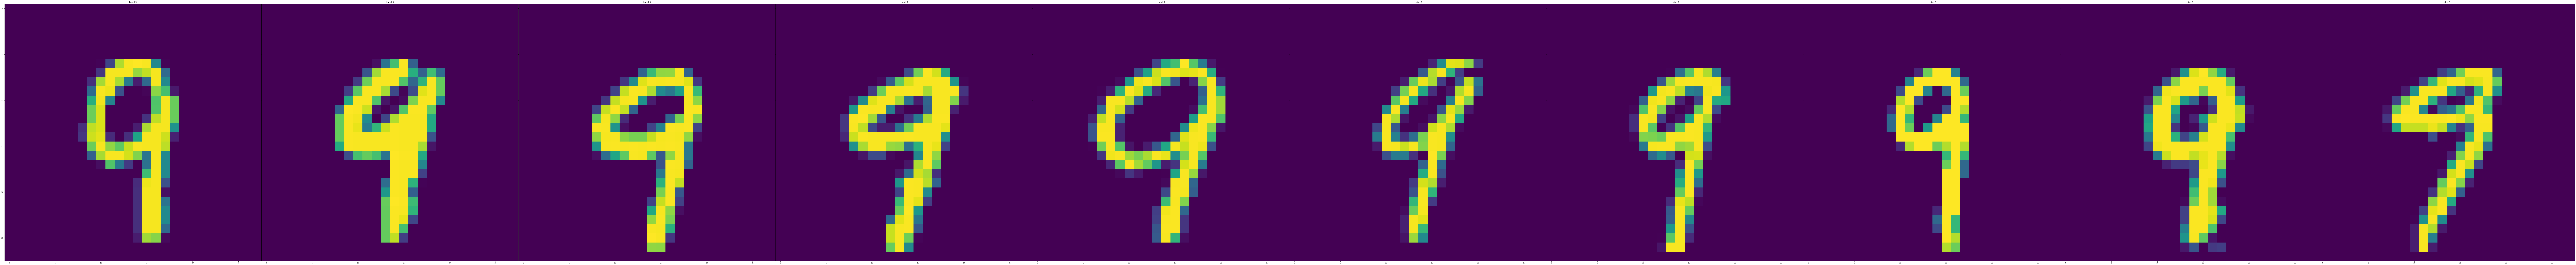

Cluster  19, size: 187


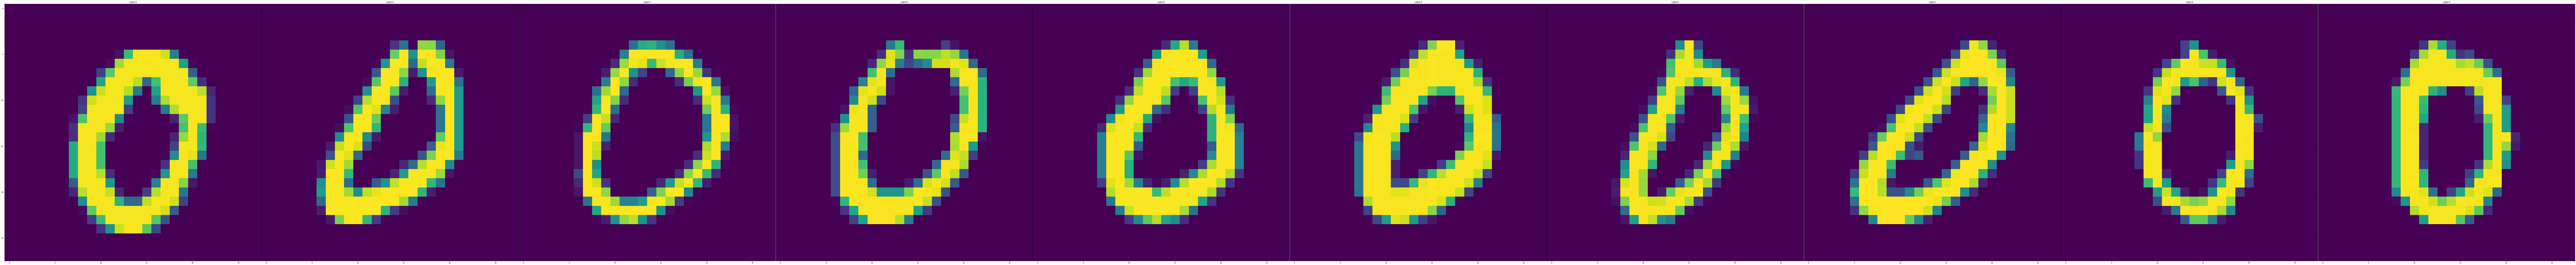

Cluster  37, size: 5


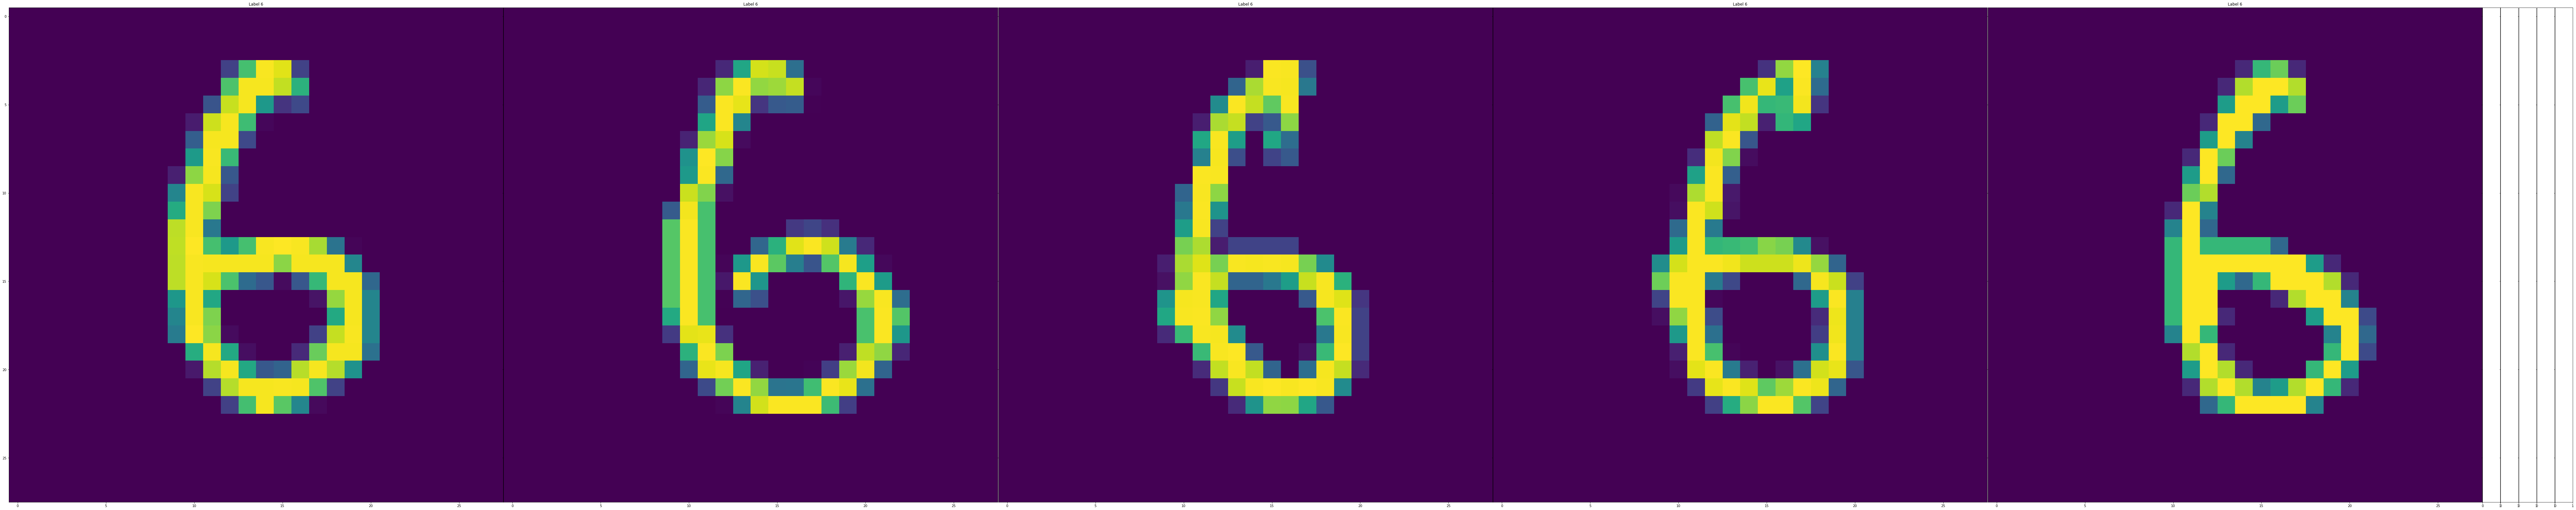

Cluster  26, size: 159


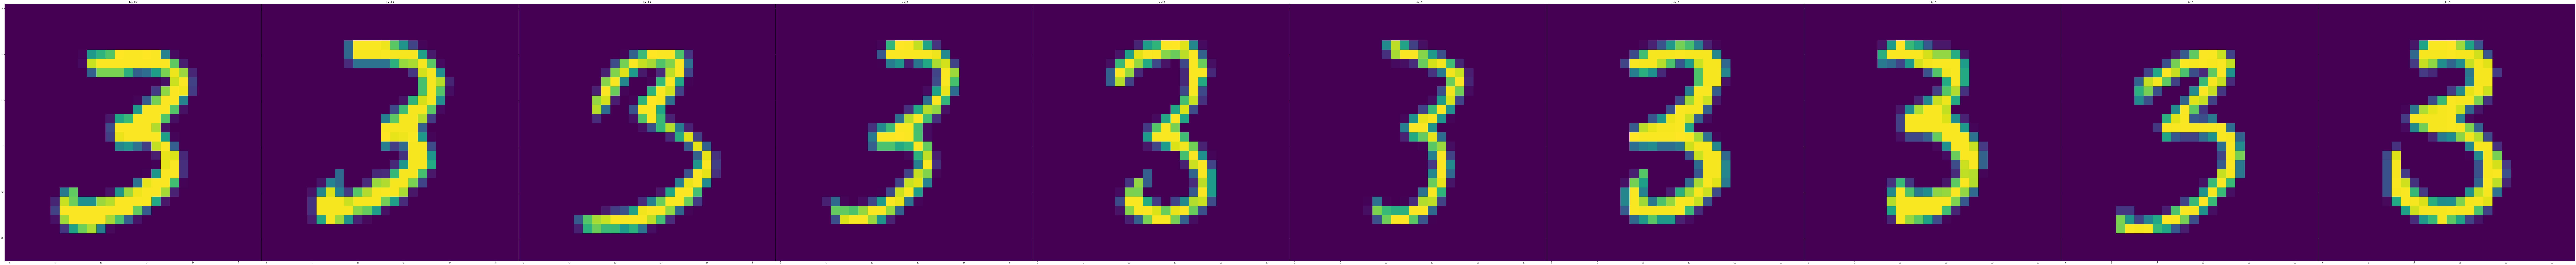

Cluster  12, size: 16


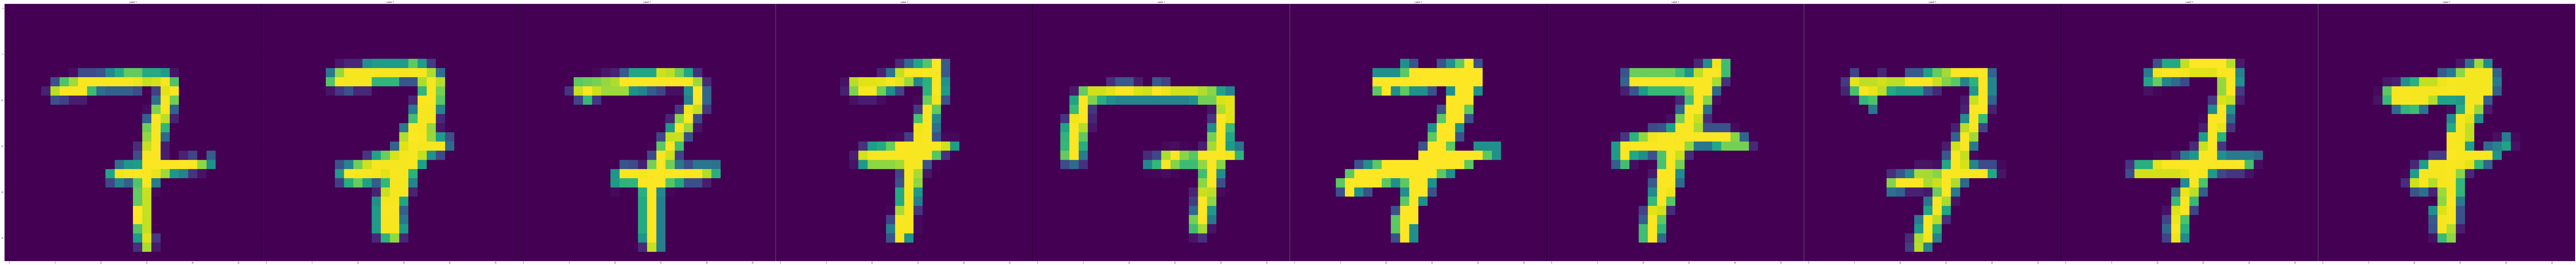

Cluster  45, size: 206


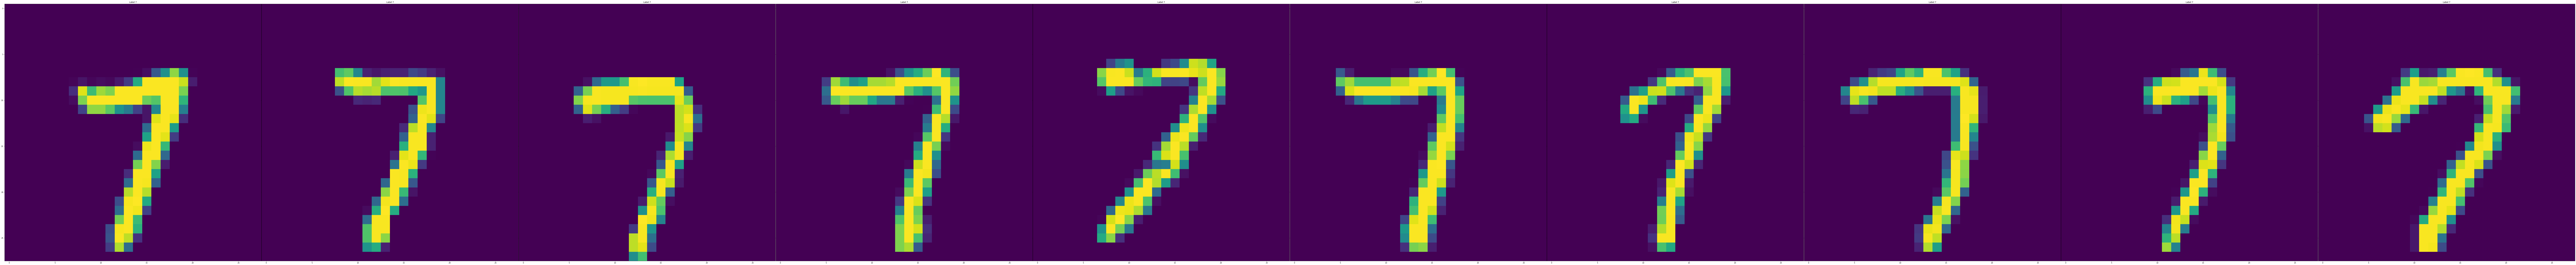

Cluster  41, size: 81


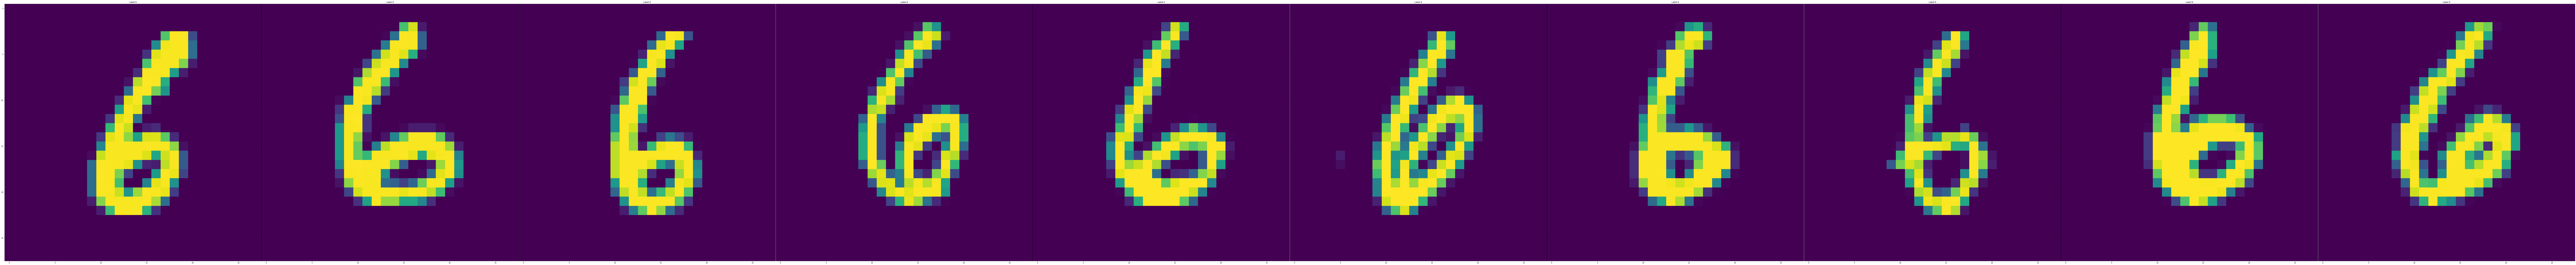

Cluster  8, size: 5


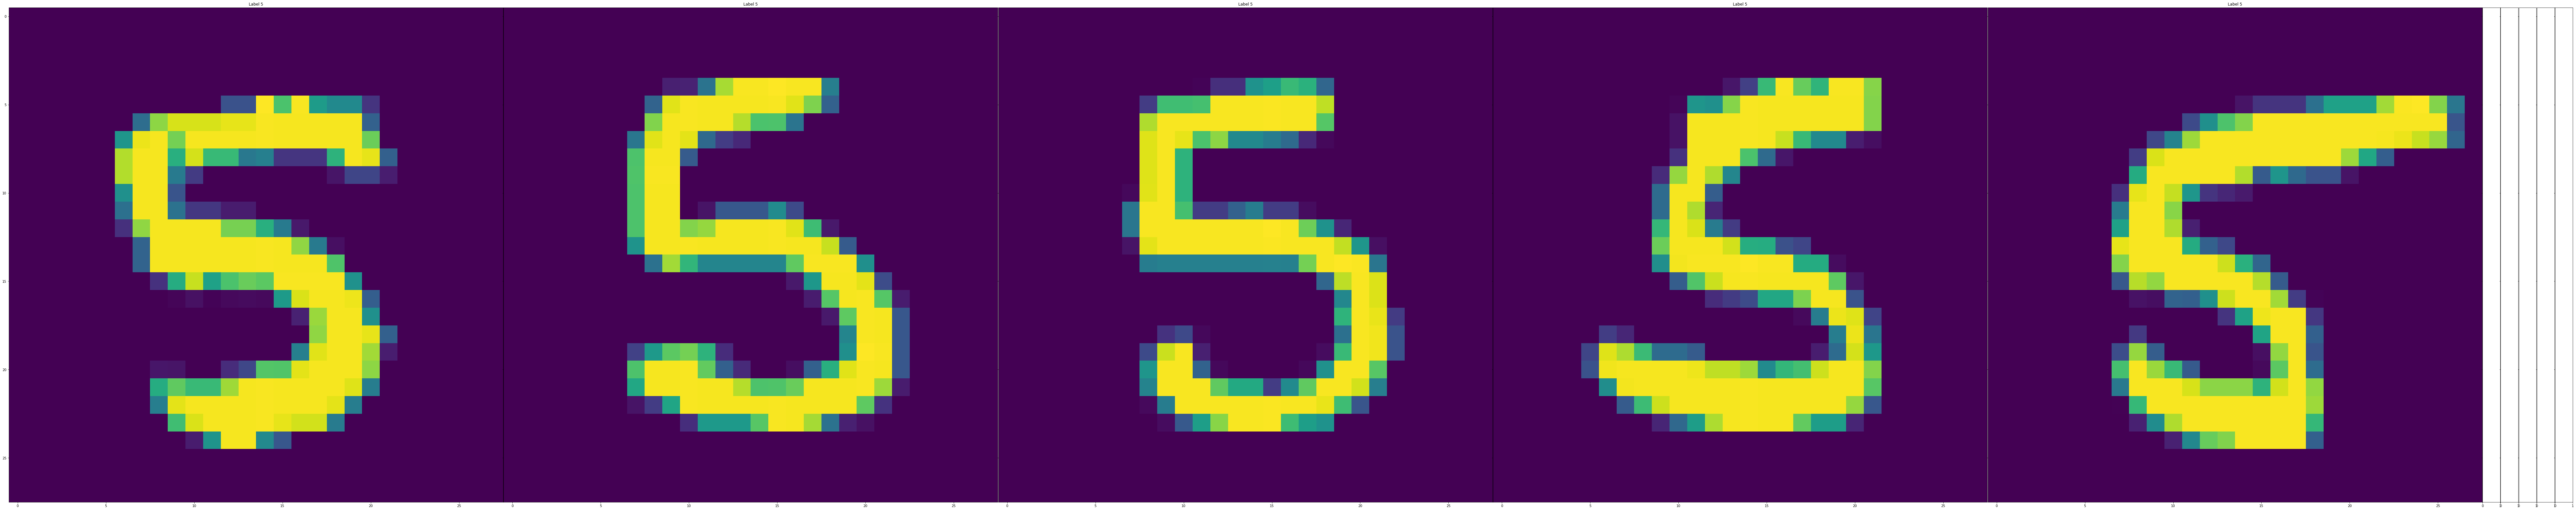

Cluster  25, size: 10


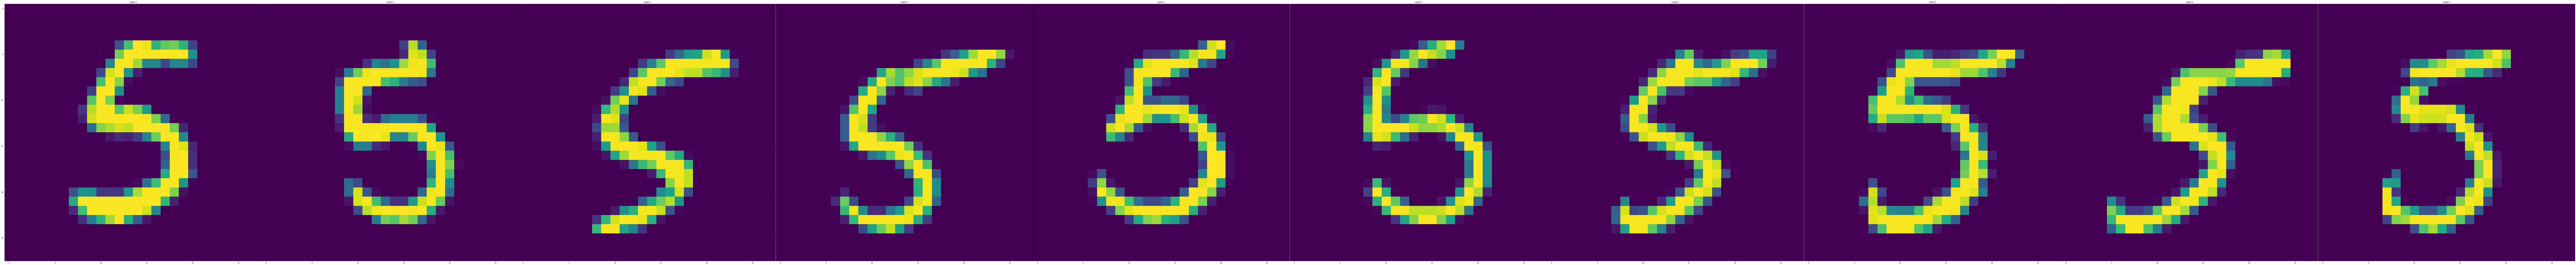

Cluster  34, size: 91


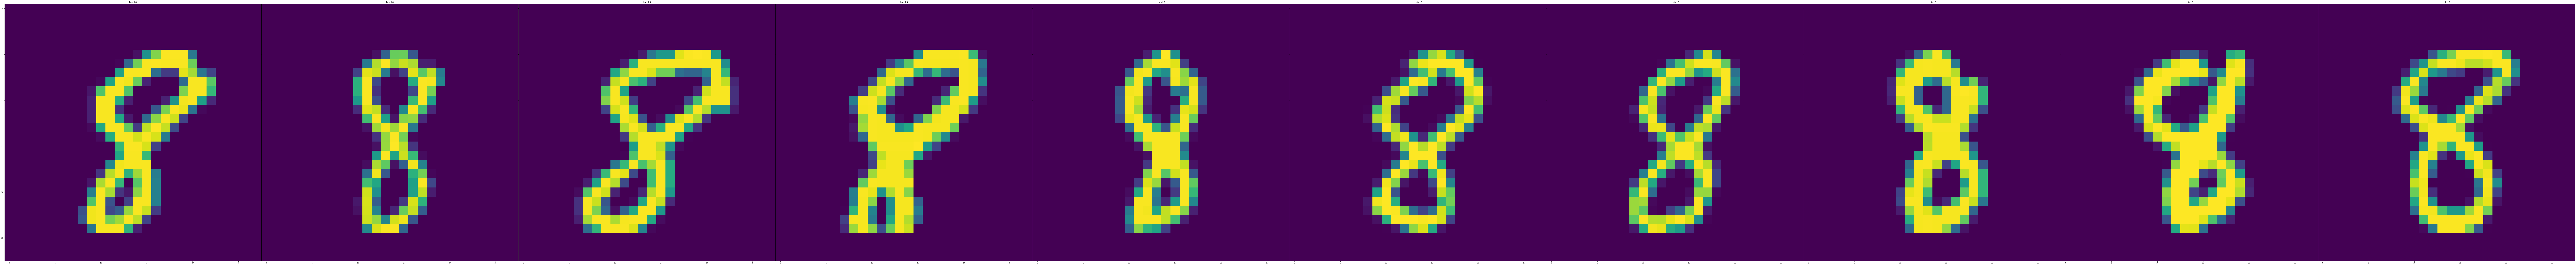

Cluster  10, size: 16


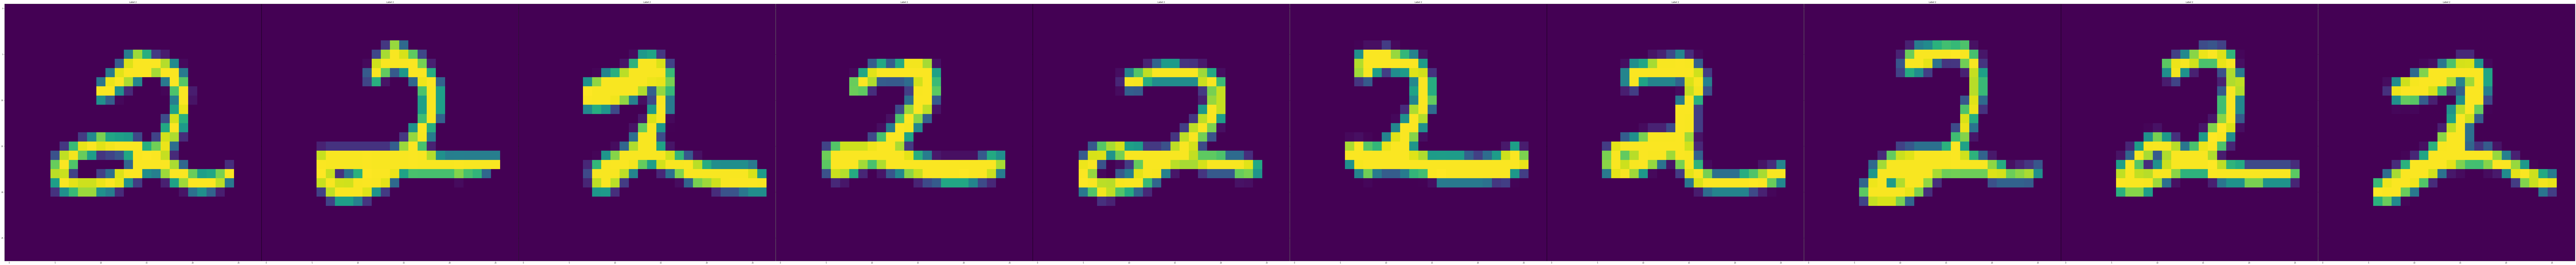

Cluster  20, size: 8


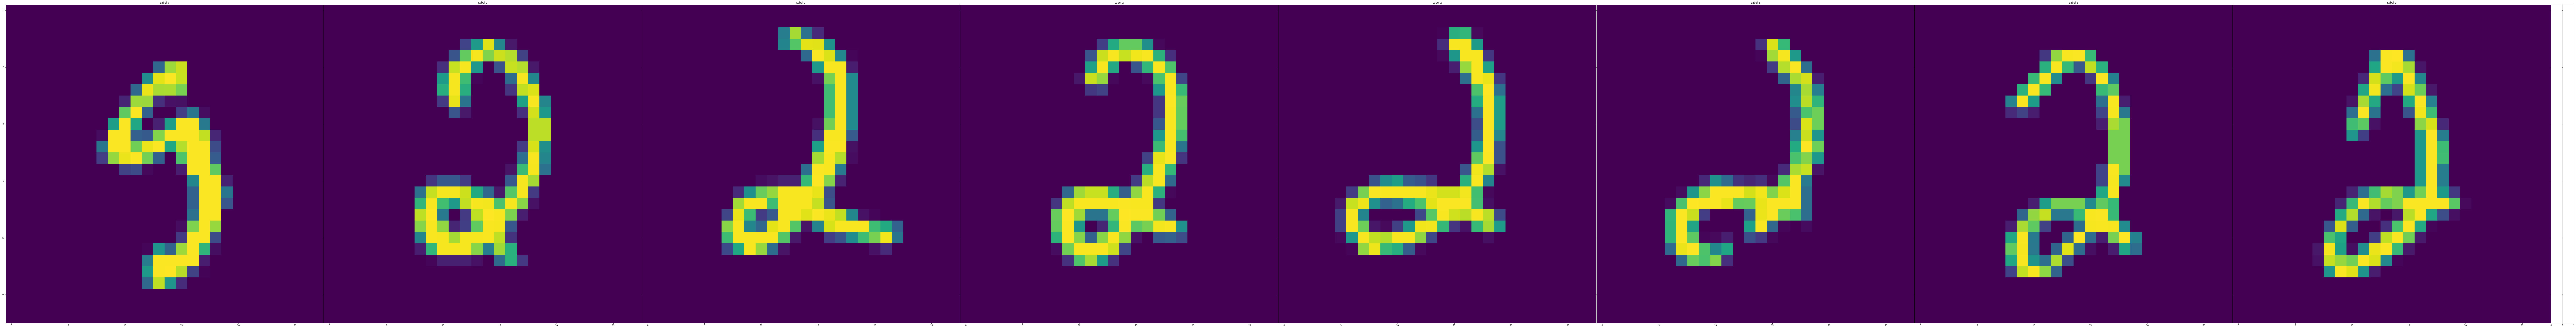

Cluster  22, size: 5


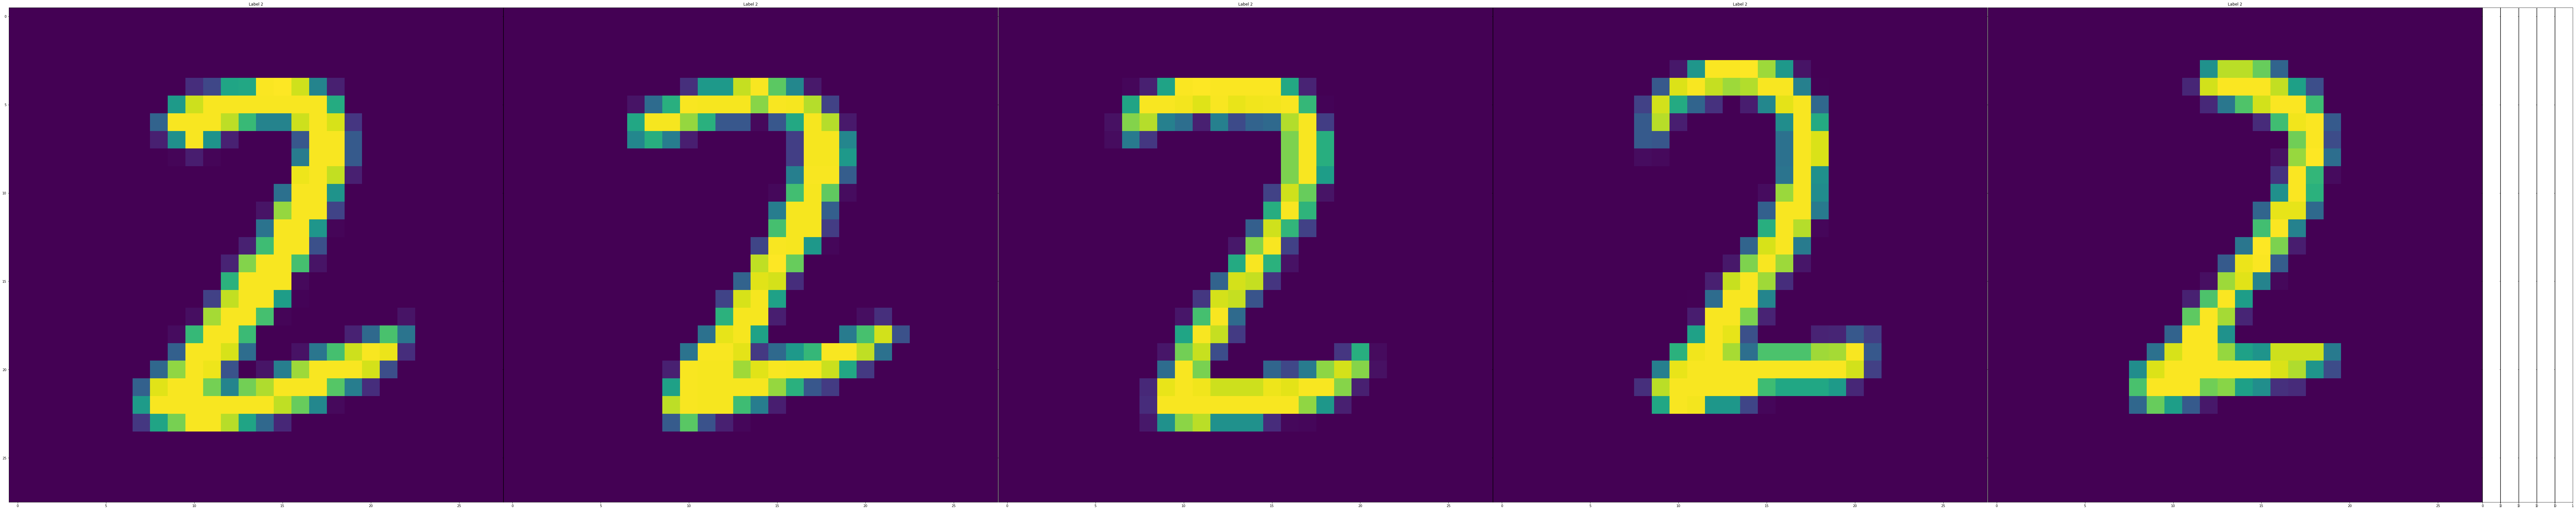

Cluster  24, size: 5


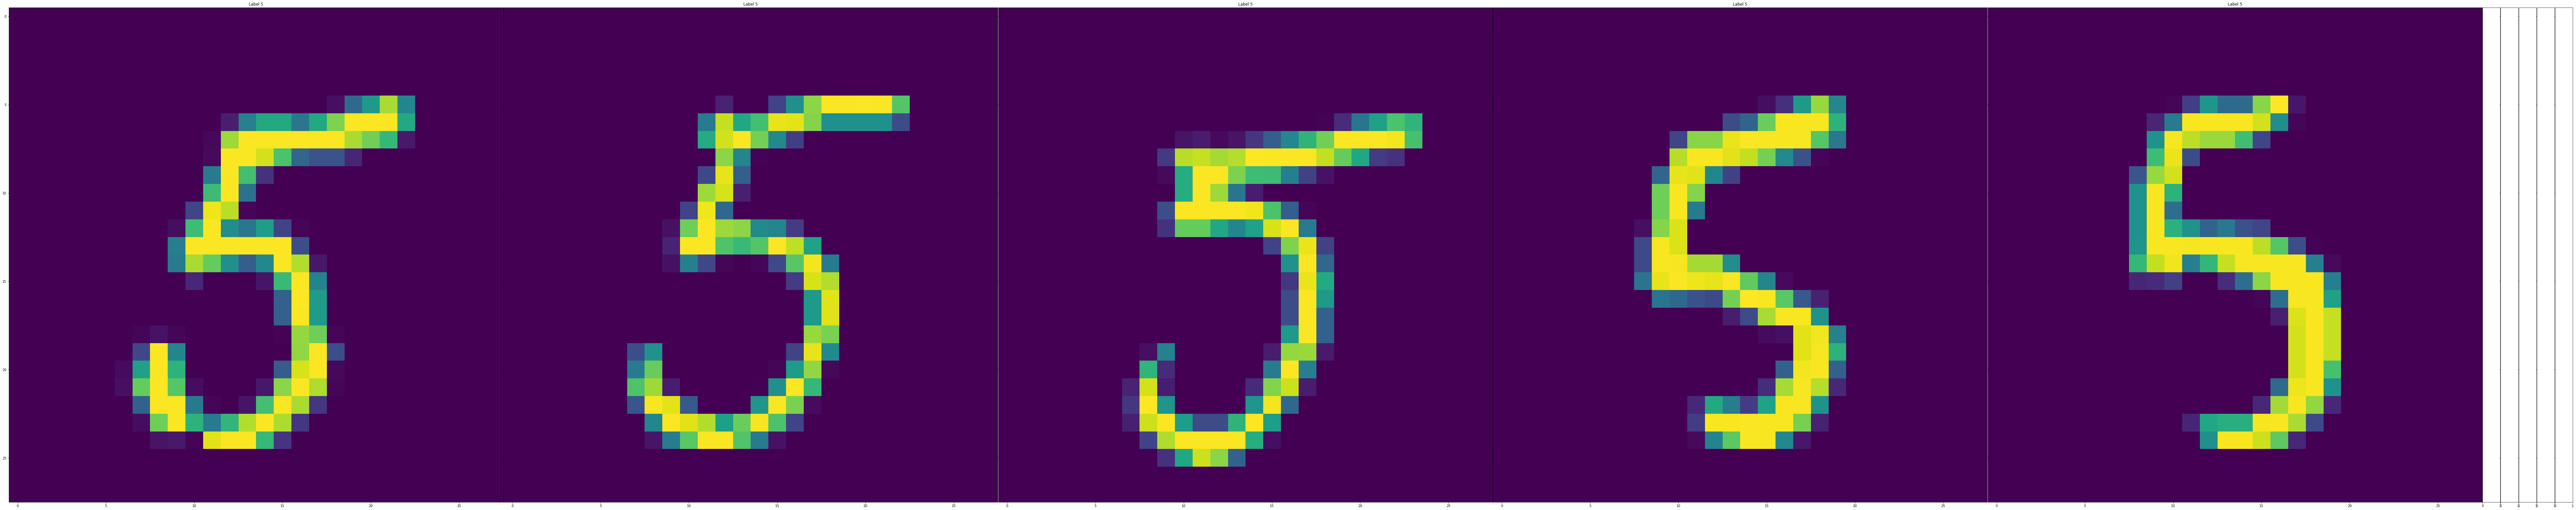

Cluster  0, size: 7


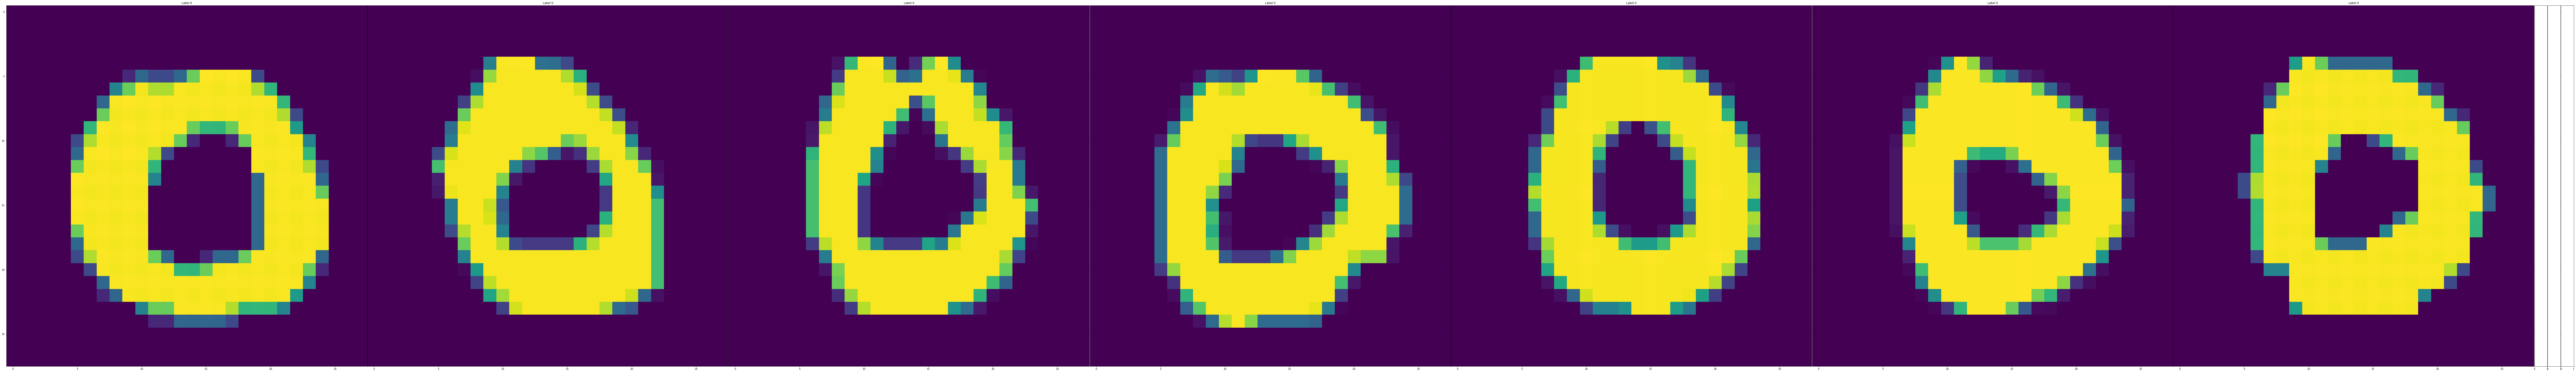

Cluster  5, size: 5


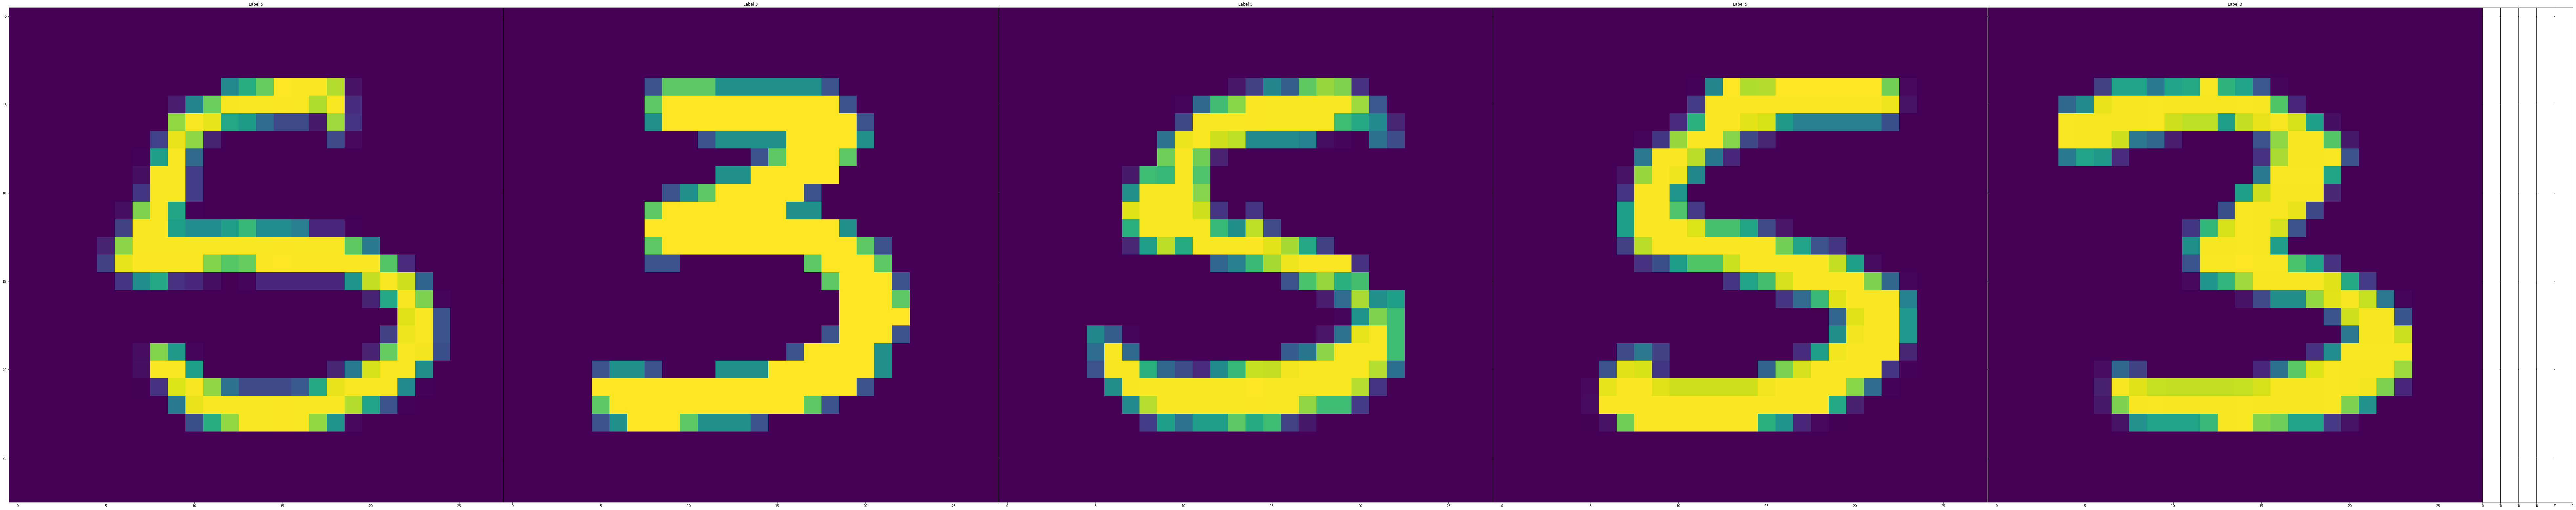

Cluster  35, size: 10


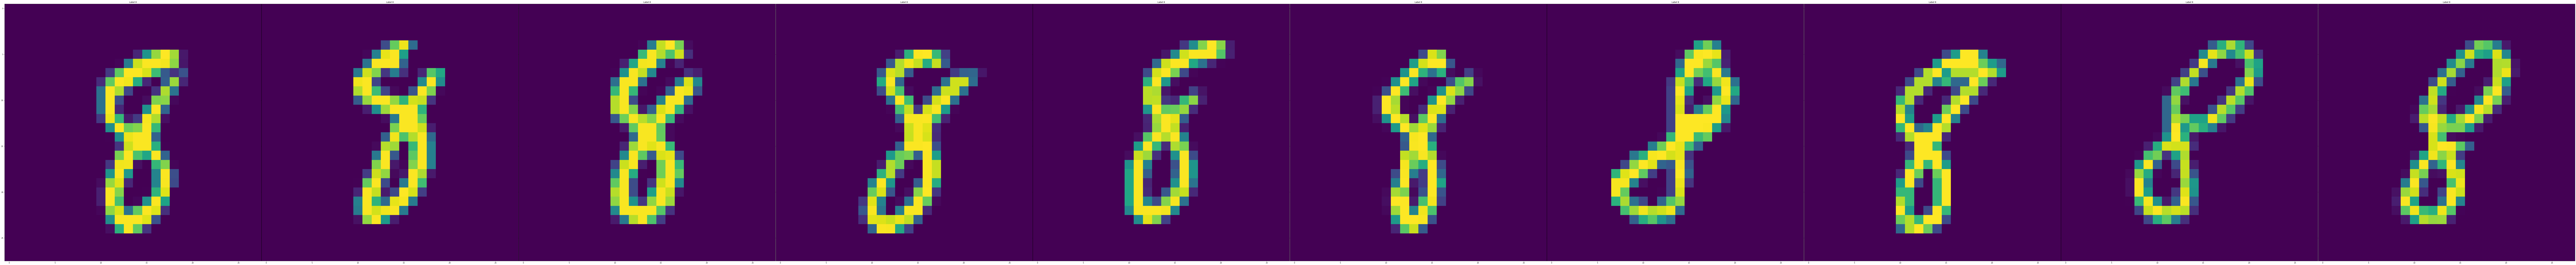

Cluster  14, size: 6


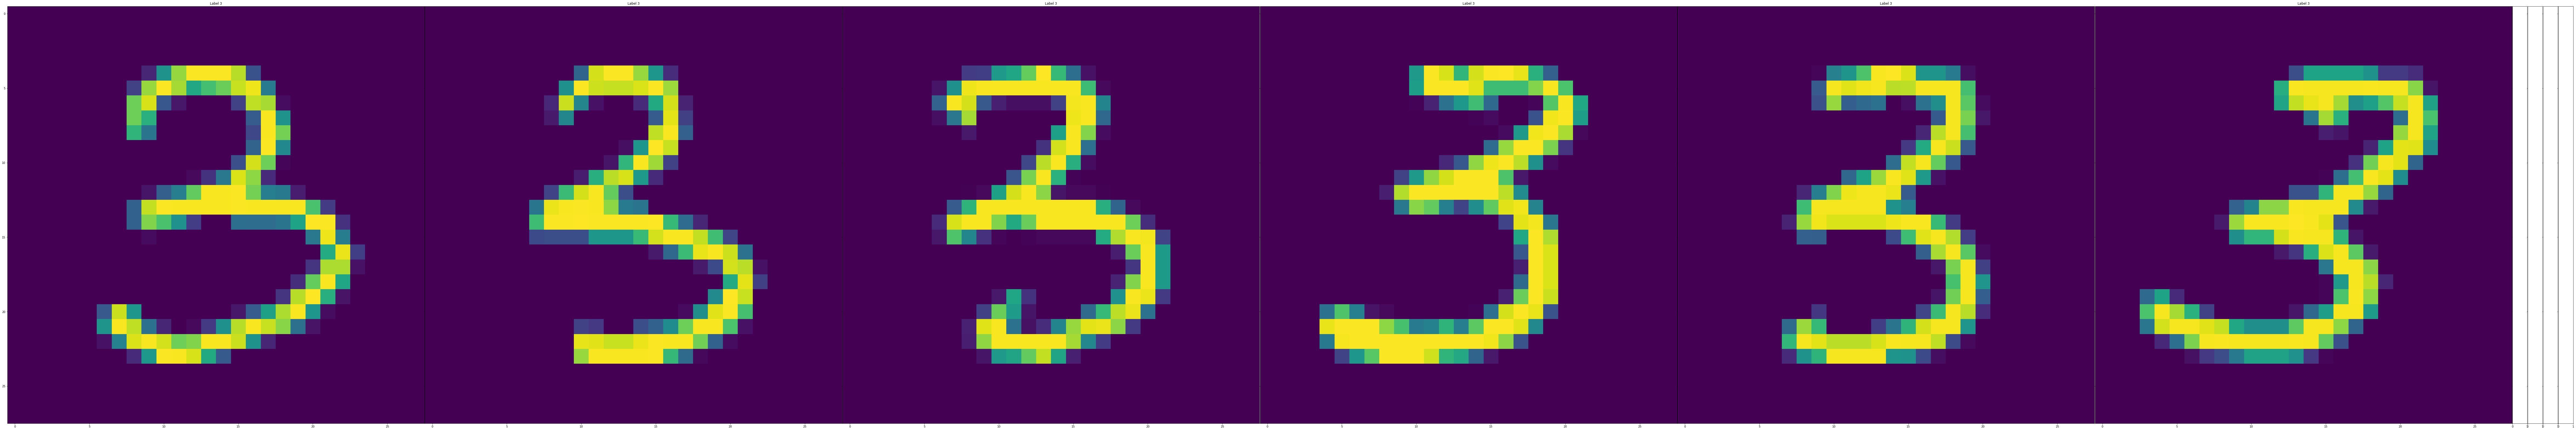

Cluster  21, size: 10


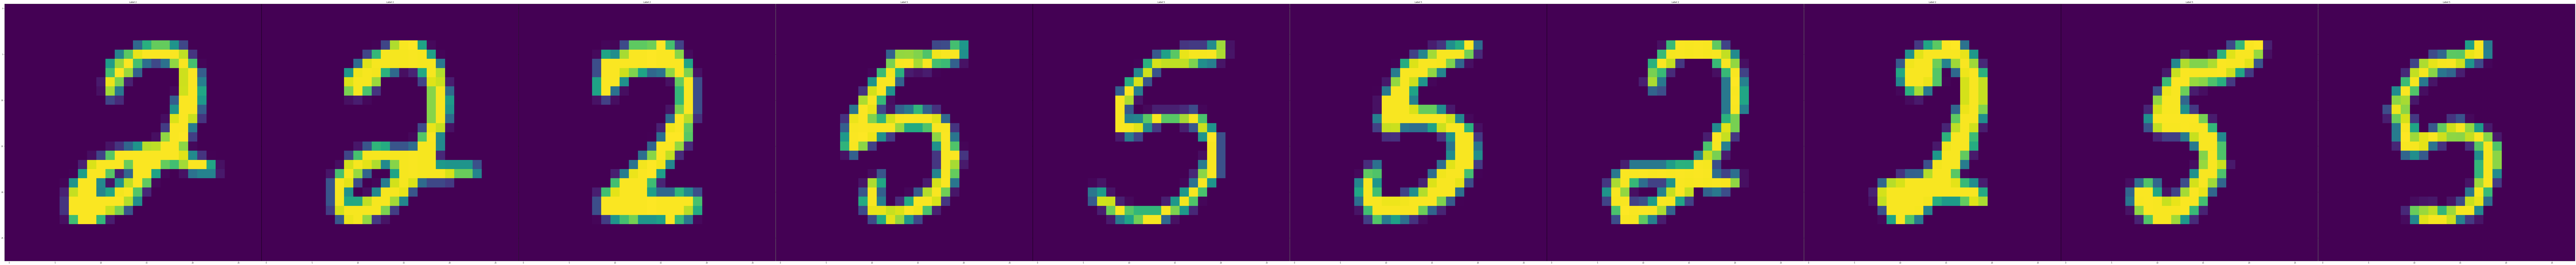

Cluster  50, size: 11


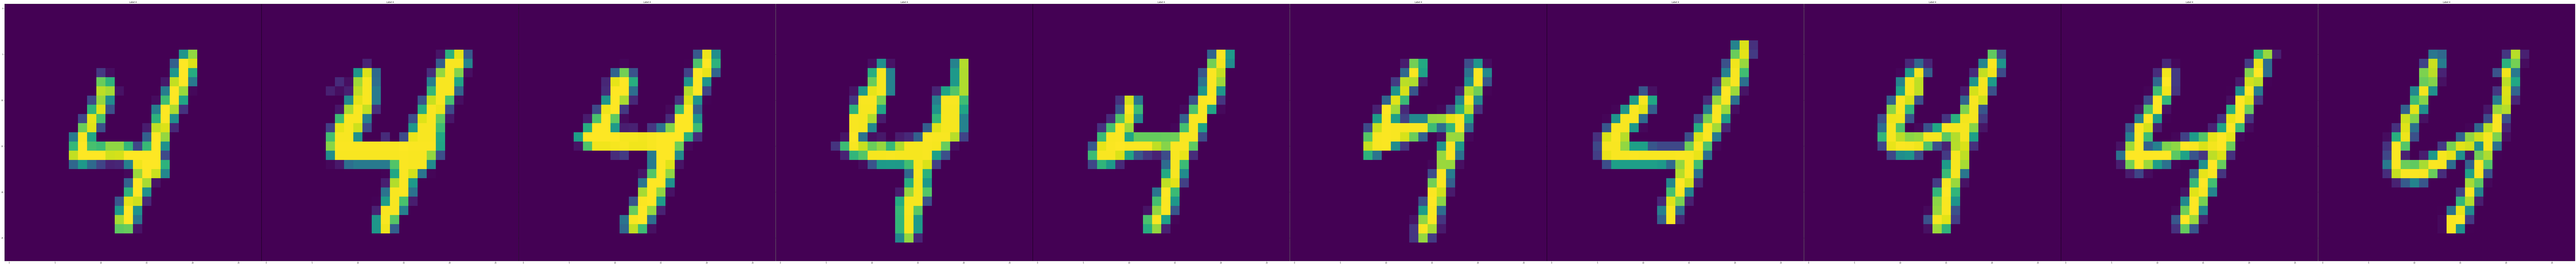

Cluster  32, size: 5


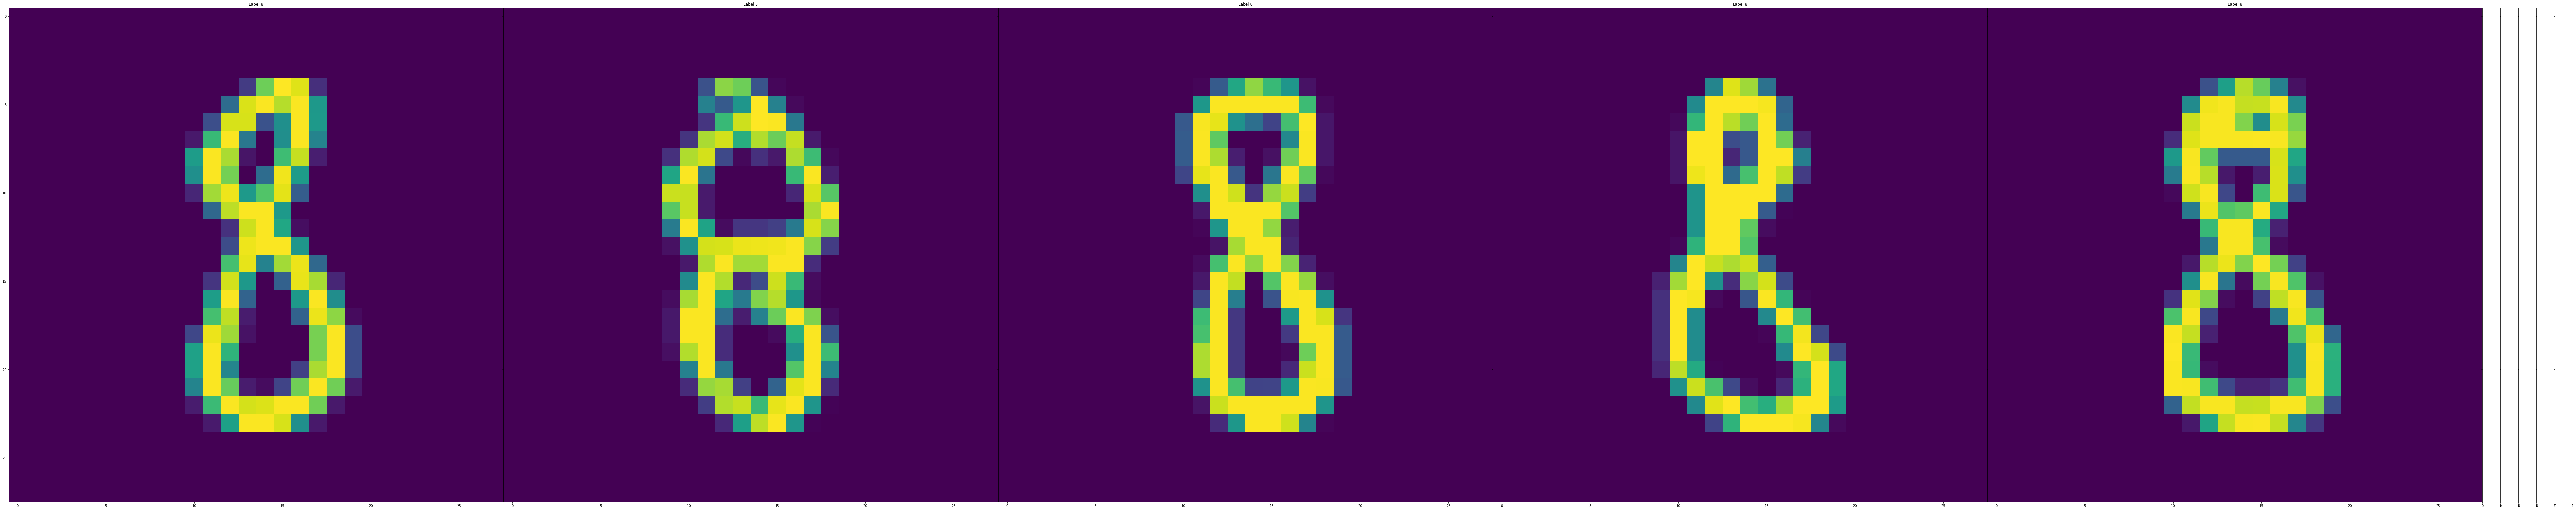

Cluster  28, size: 6


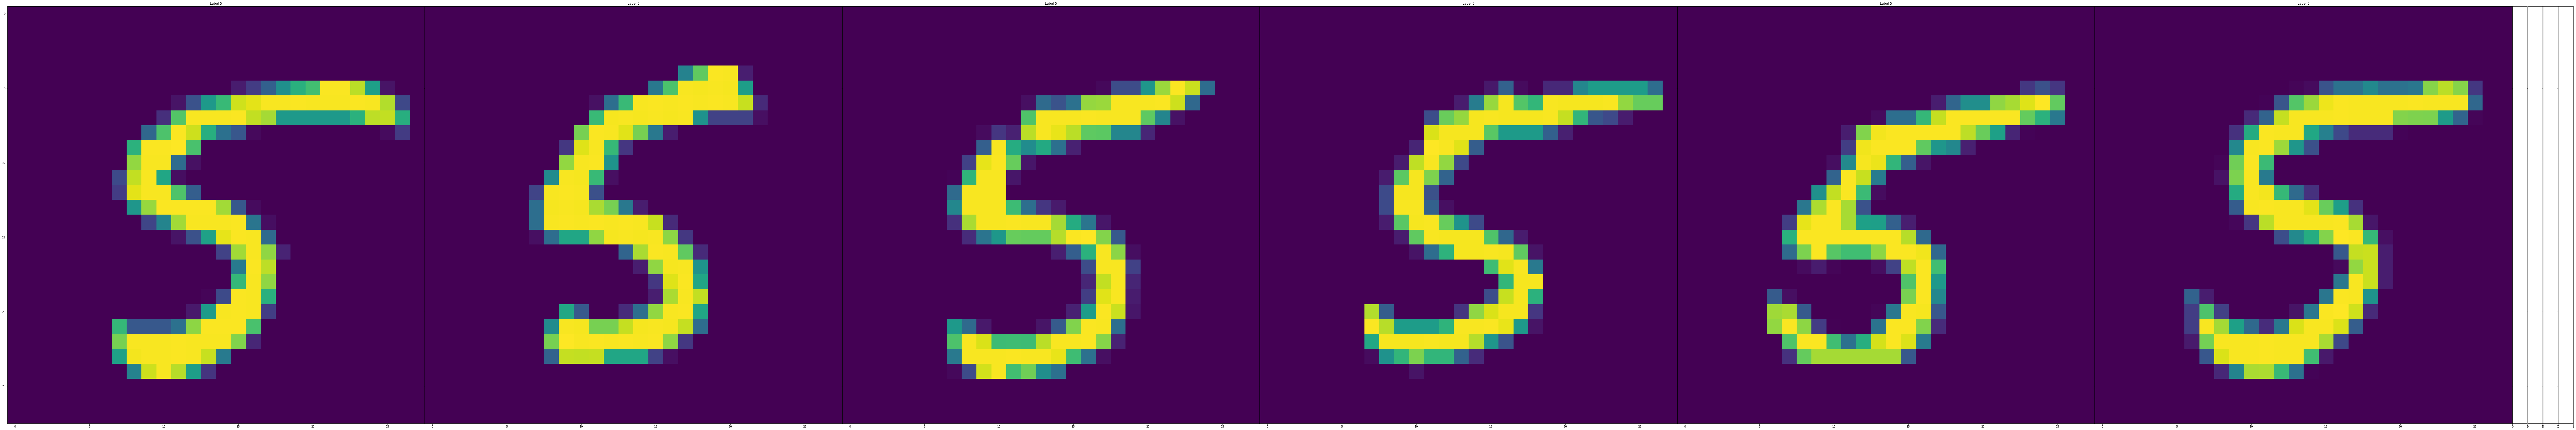

Cluster  36, size: 7


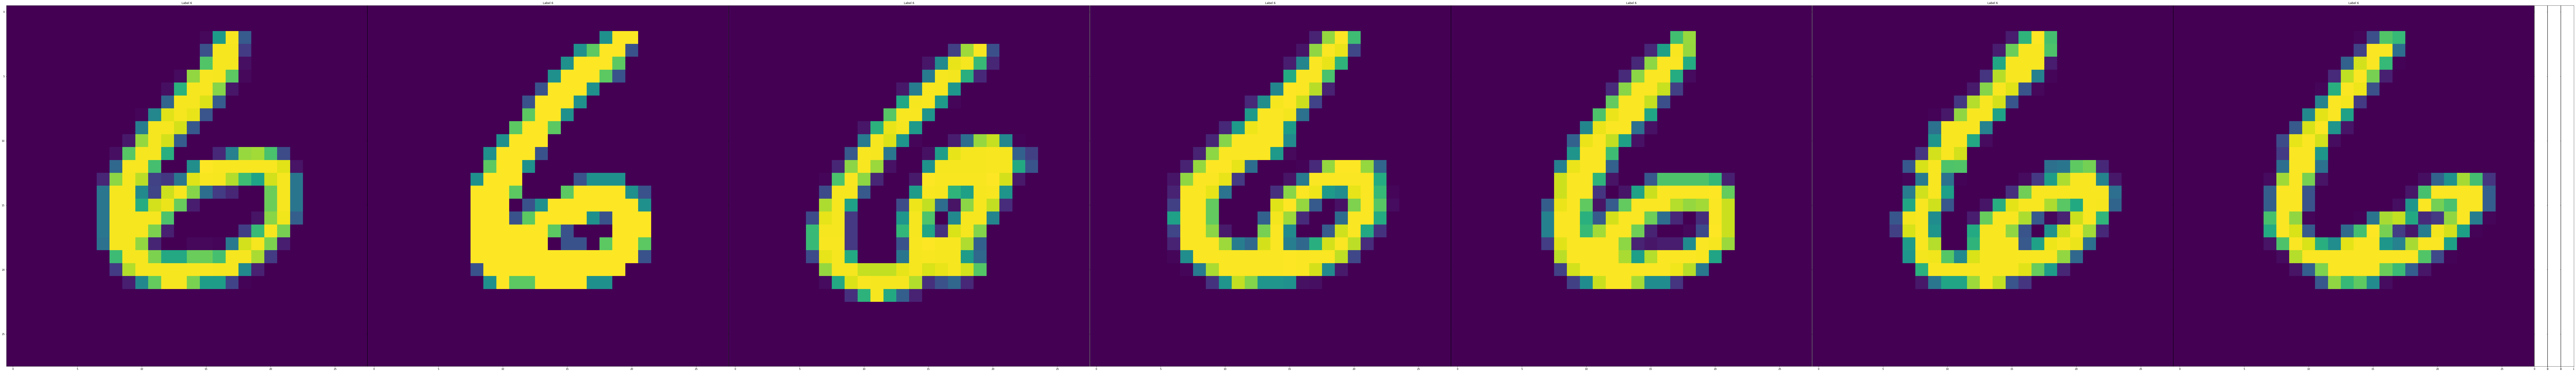

Cluster  38, size: 6


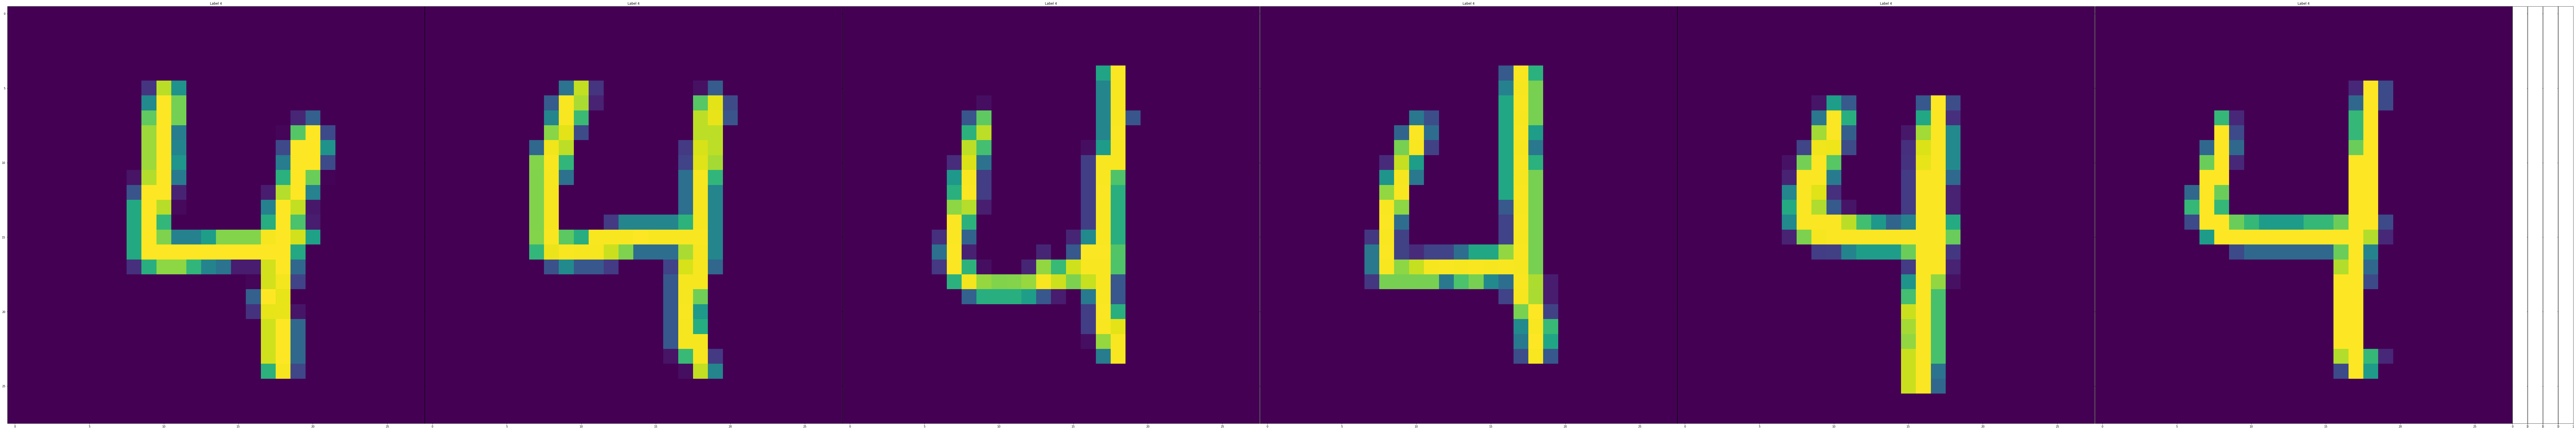

Cluster  23, size: 5


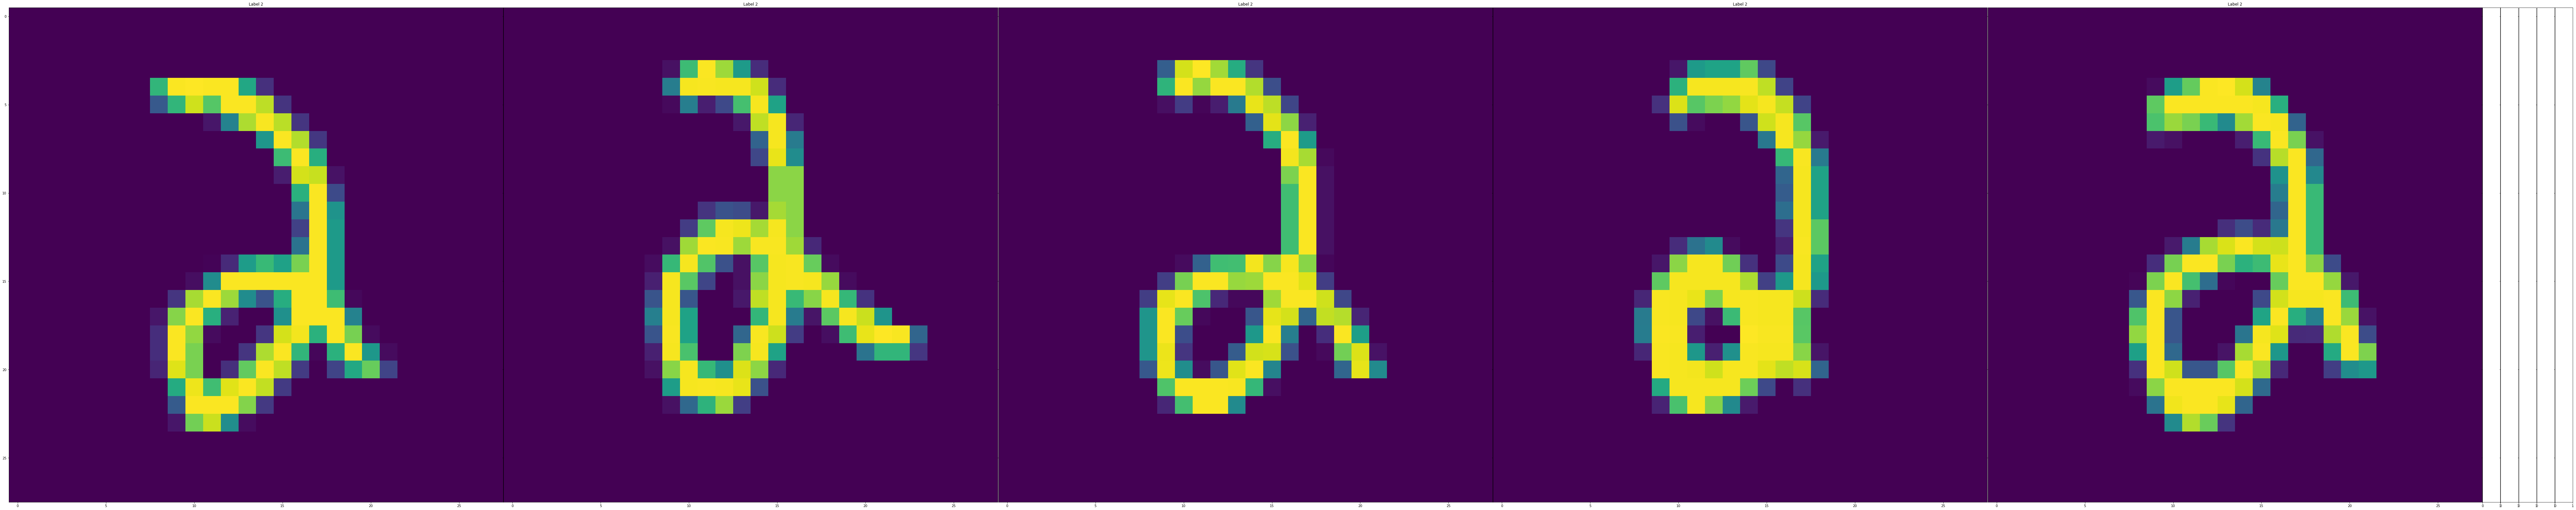

Cluster  18, size: 6


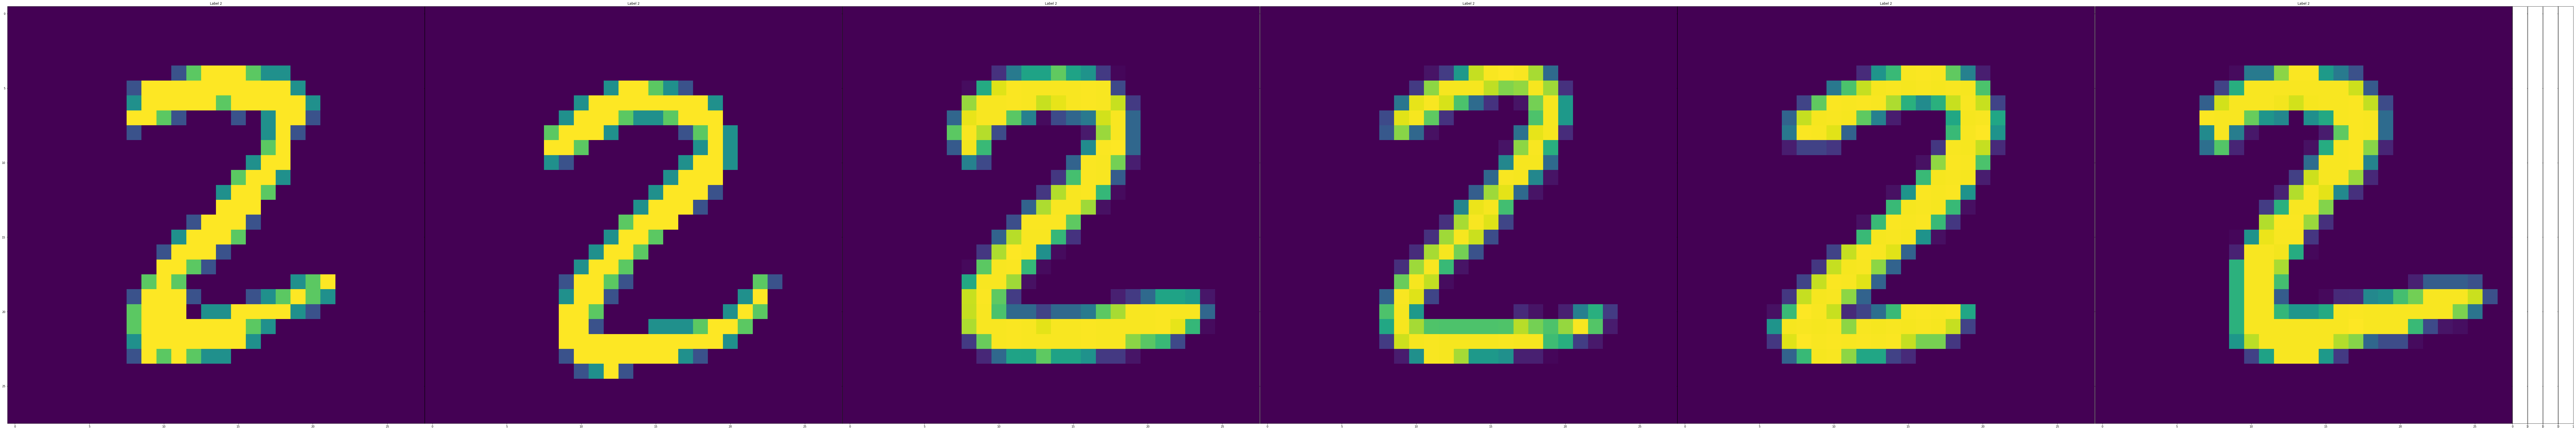

Cluster  1, size: 6


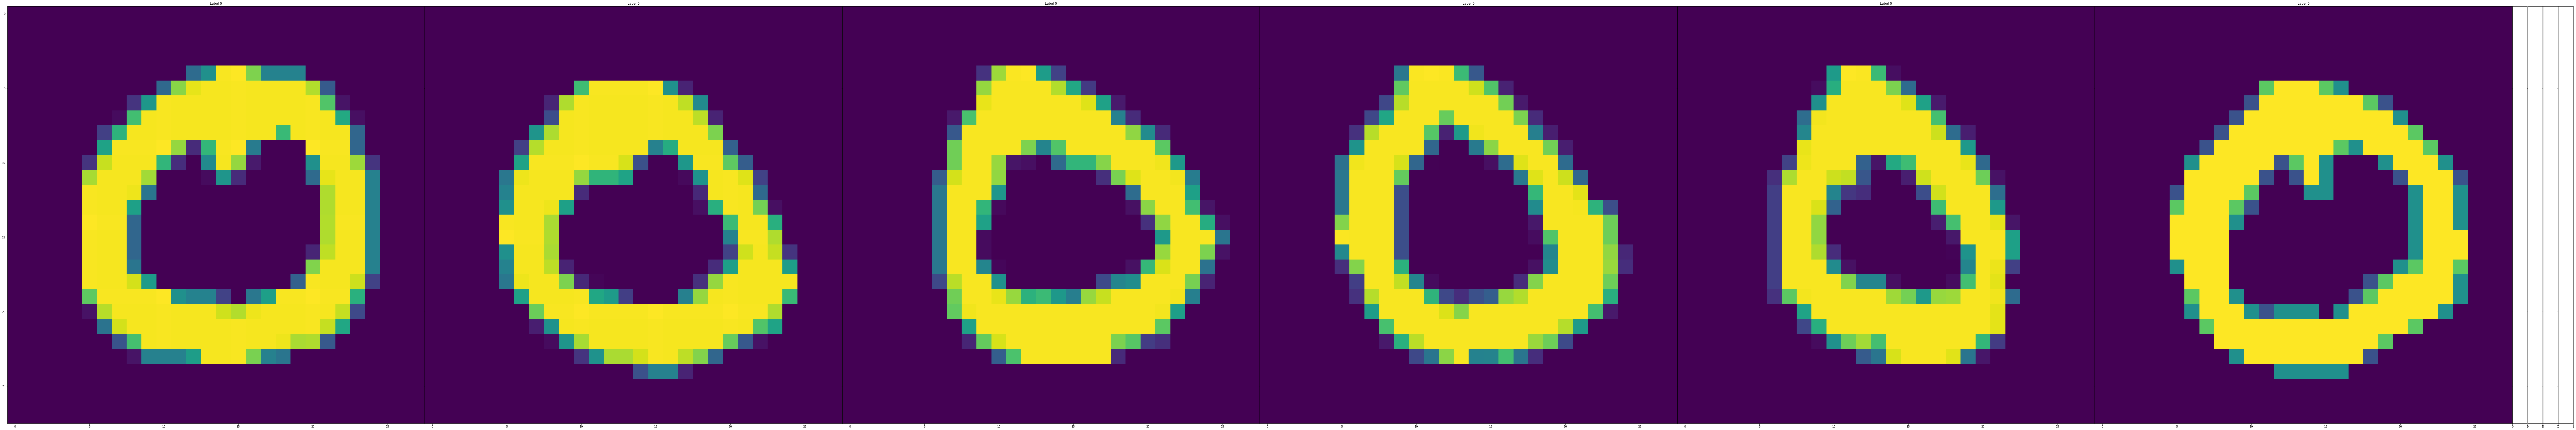

Cluster  51, size: 19


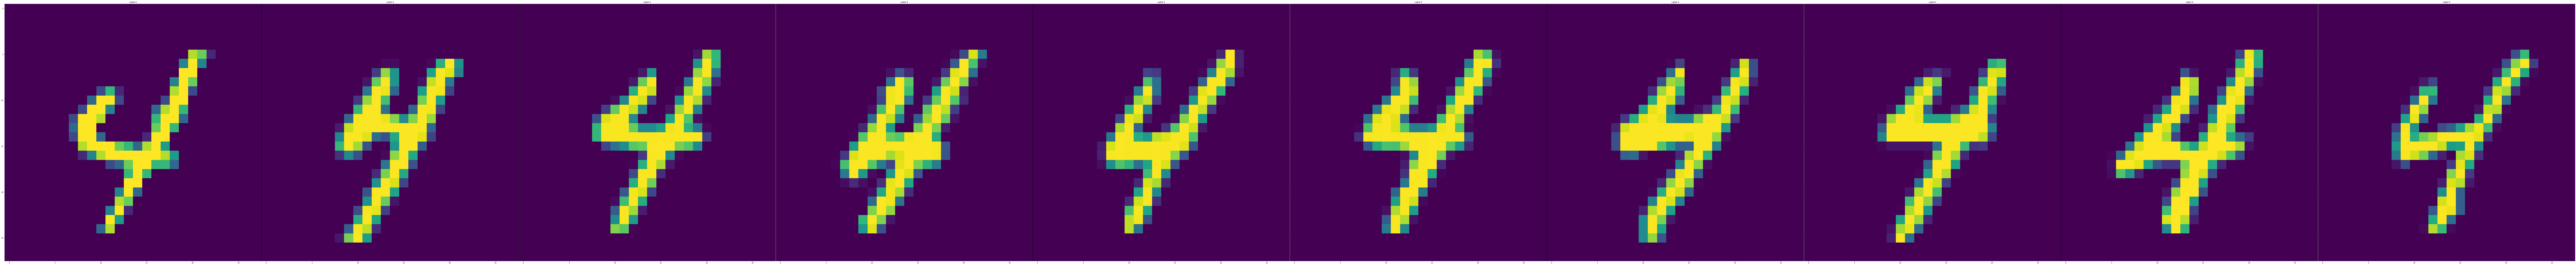

Cluster  6, size: 7


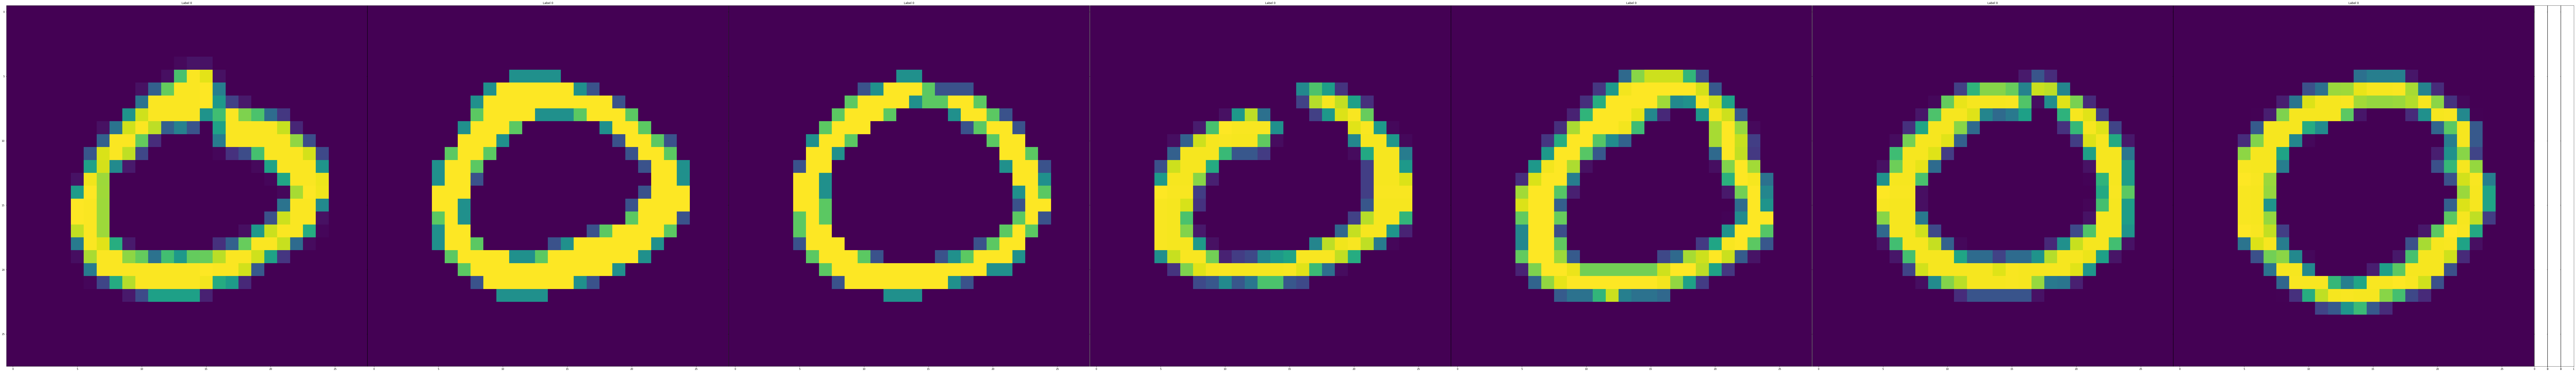

Cluster  30, size: 5


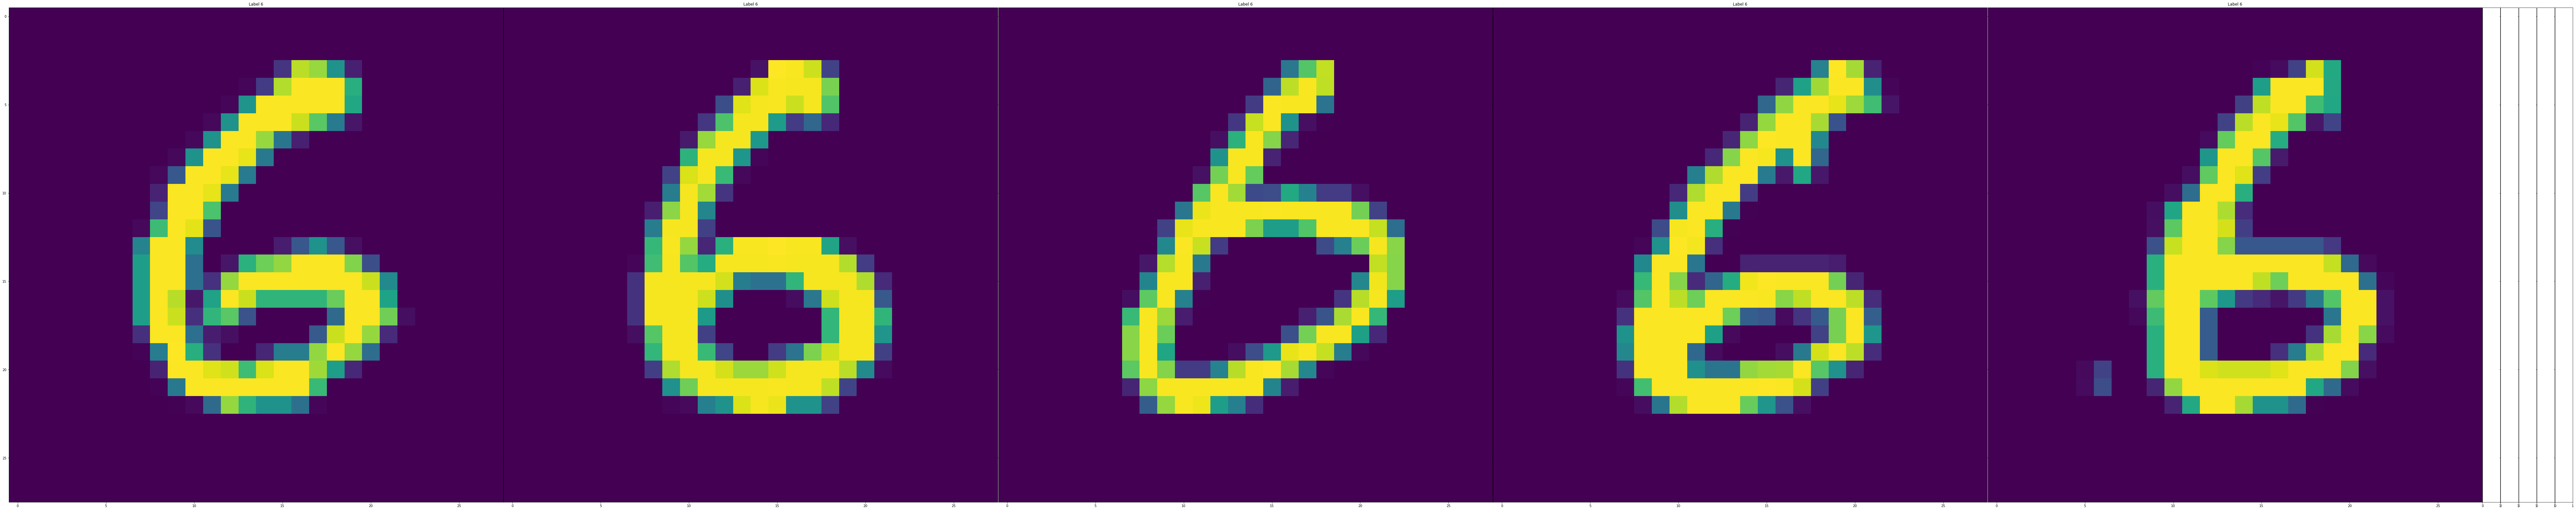

Cluster  33, size: 7


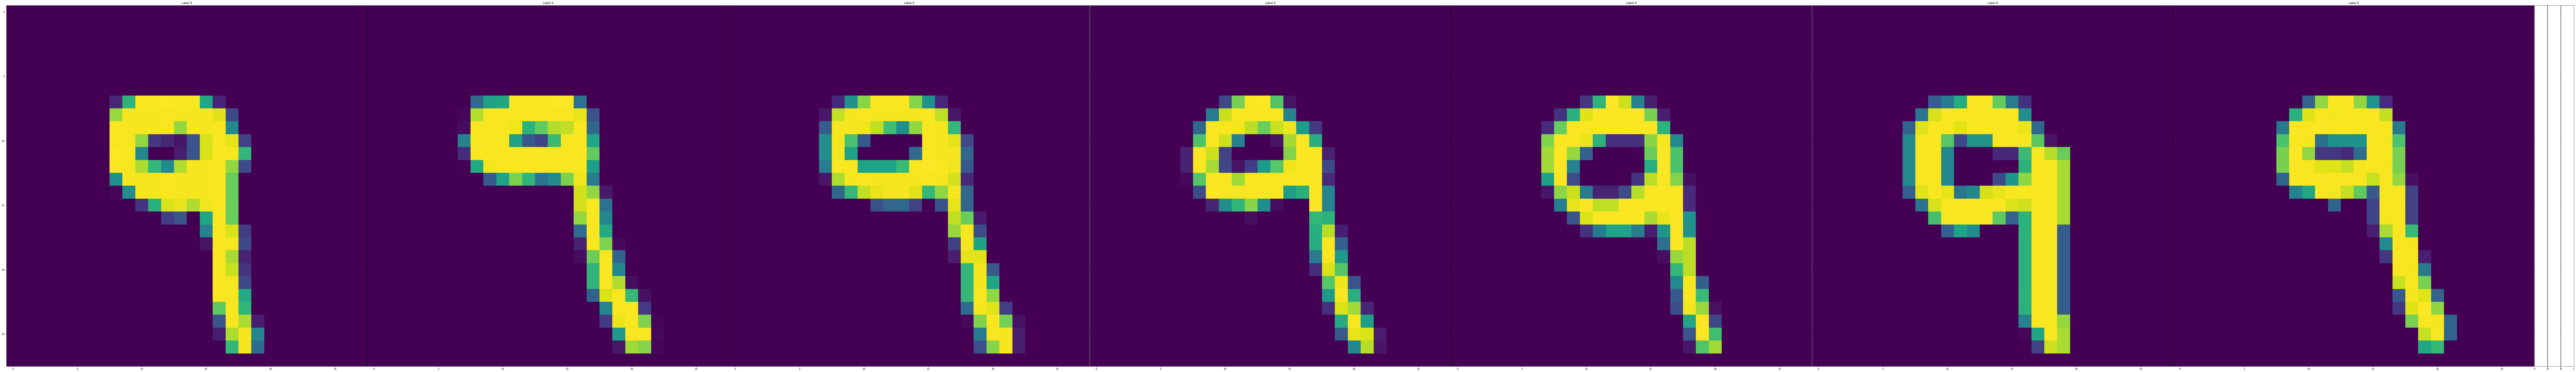

Cluster  27, size: 14


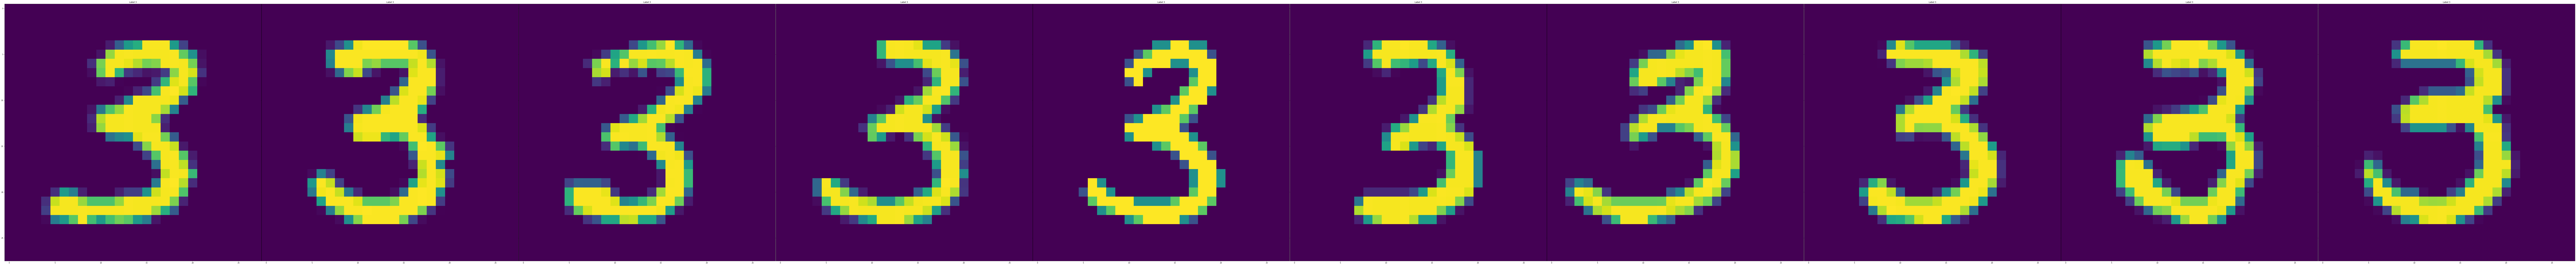

Cluster  3, size: 6


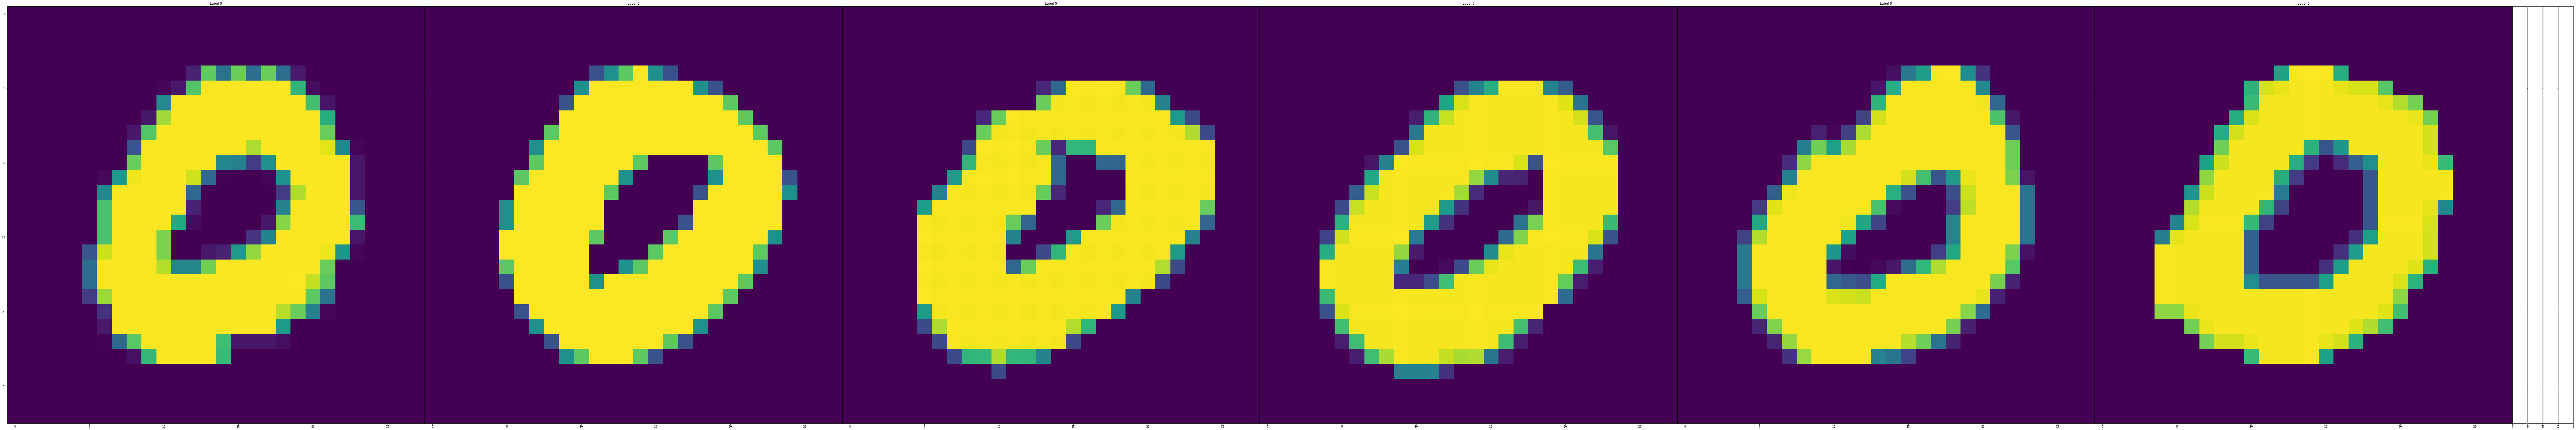

Cluster  40, size: 5


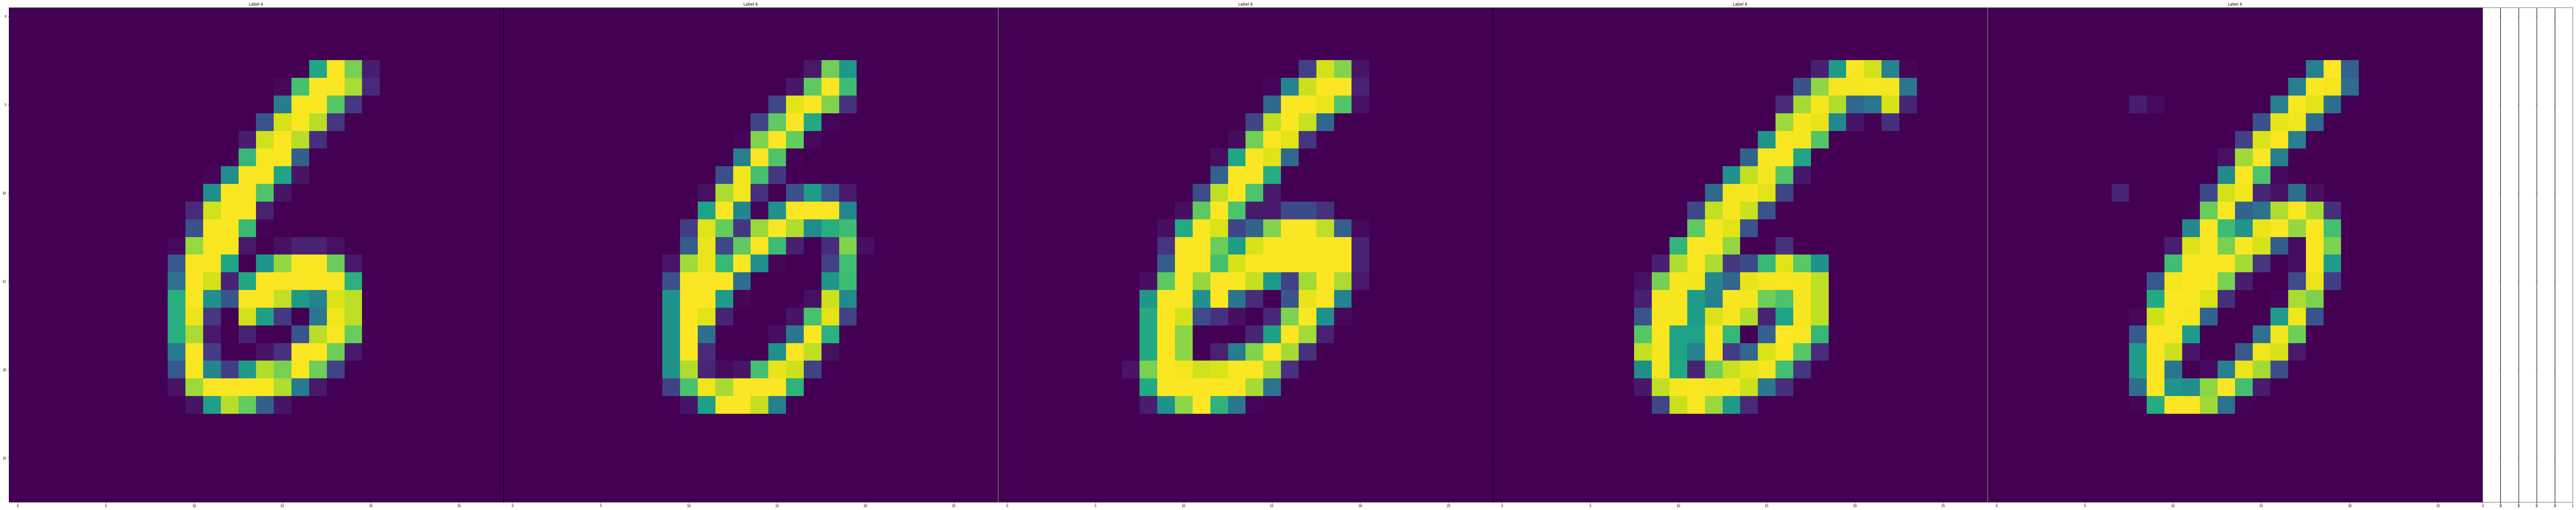

Cluster  16, size: 5


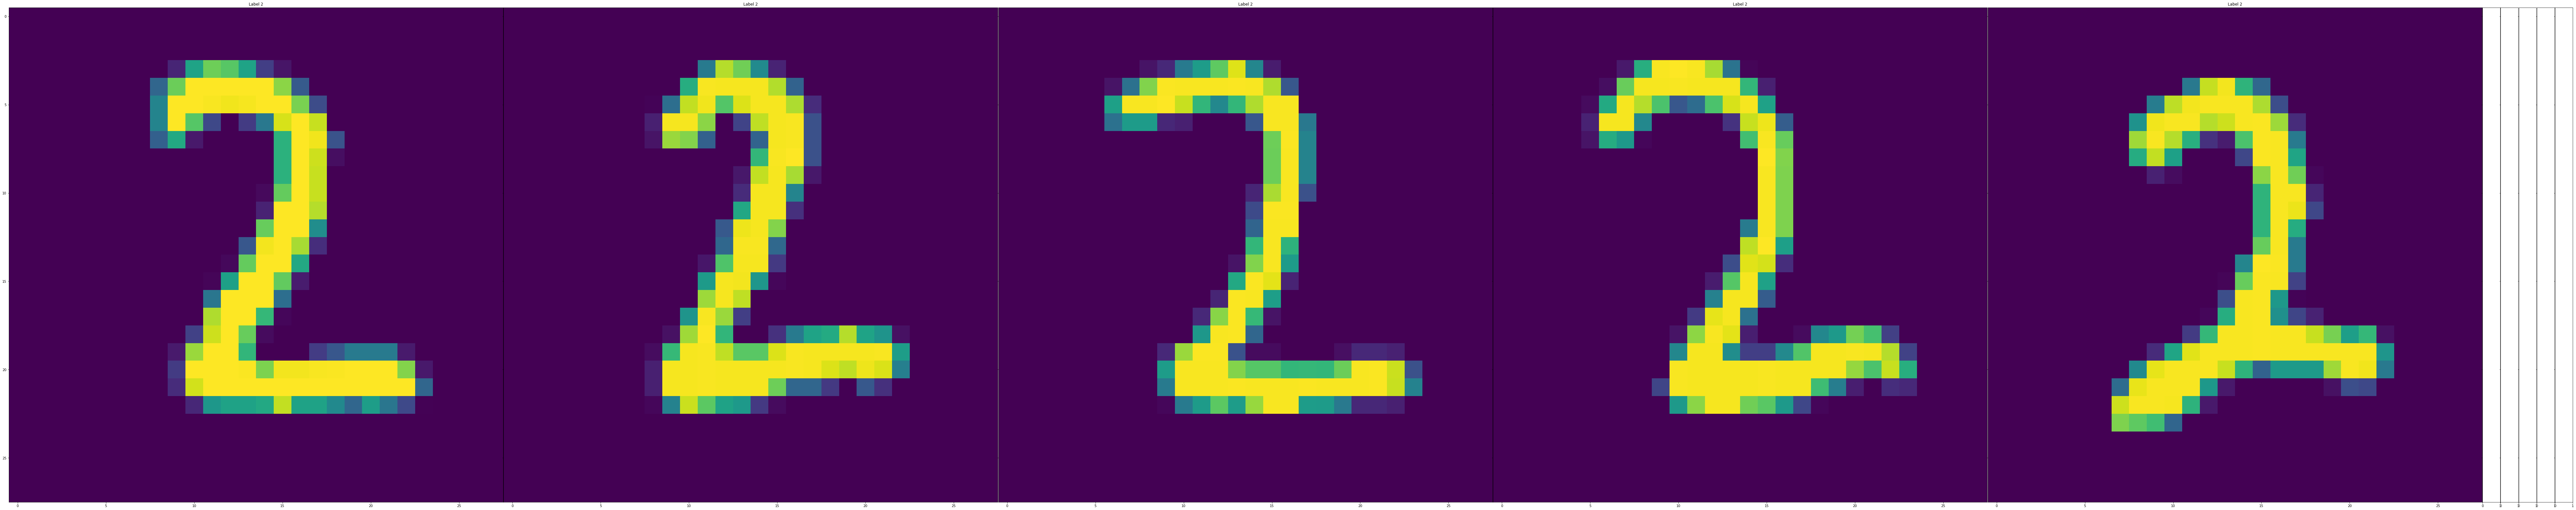

Cluster  15, size: 9


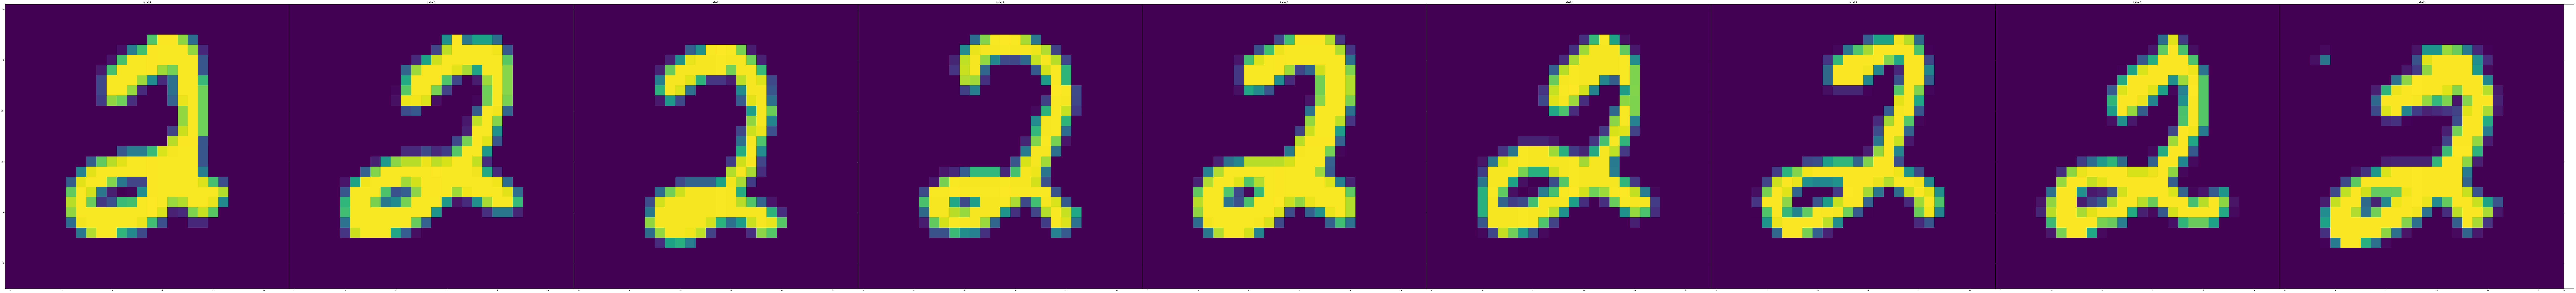

Cluster  29, size: 39


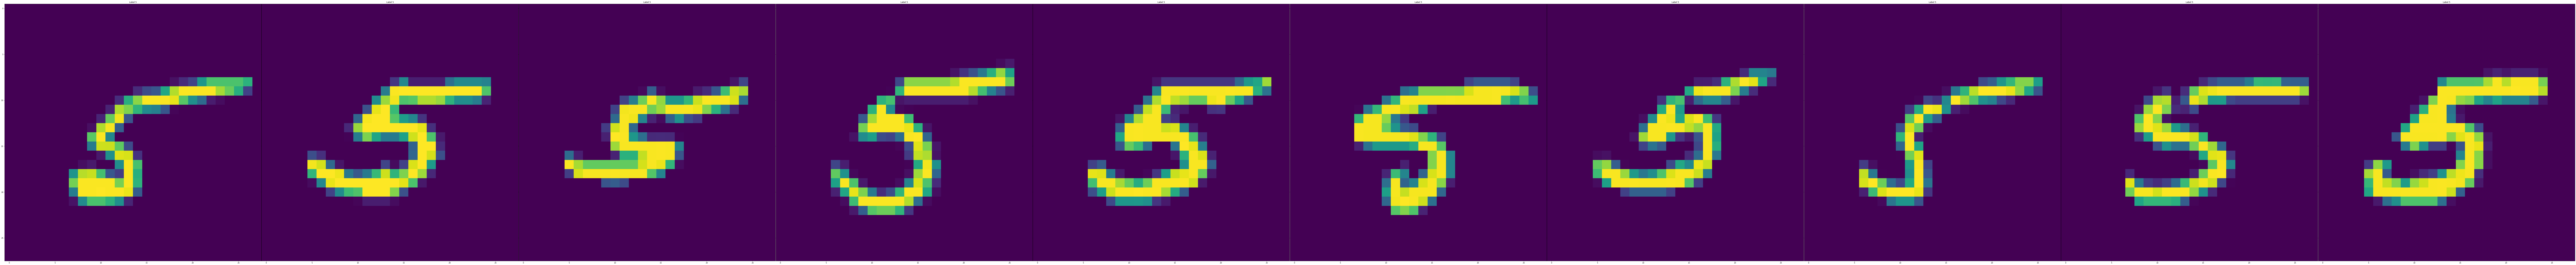

Cluster  17, size: 5


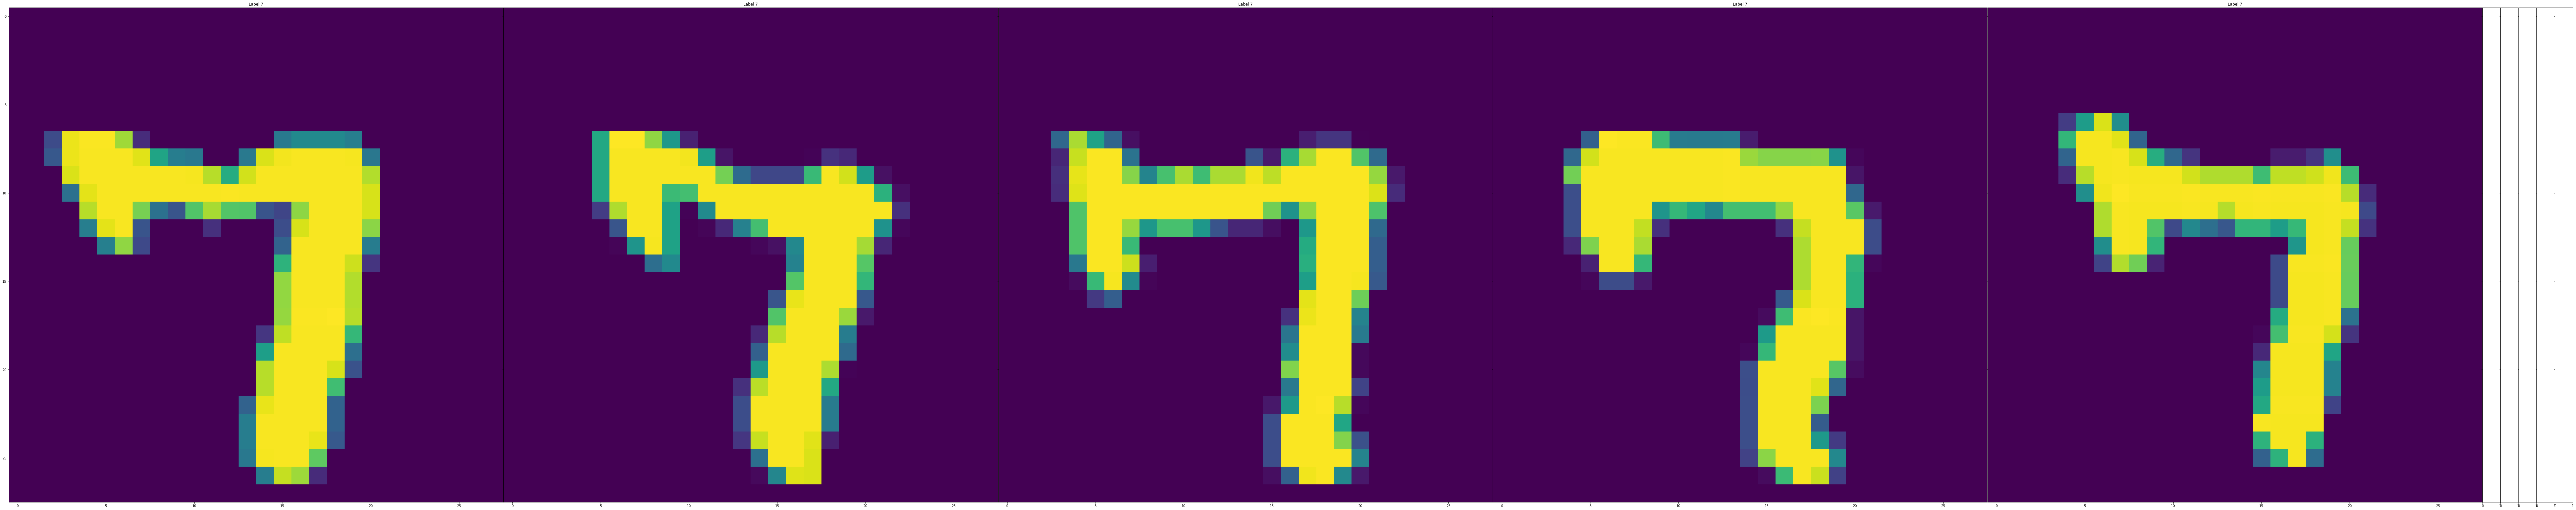

Cluster  48, size: 6


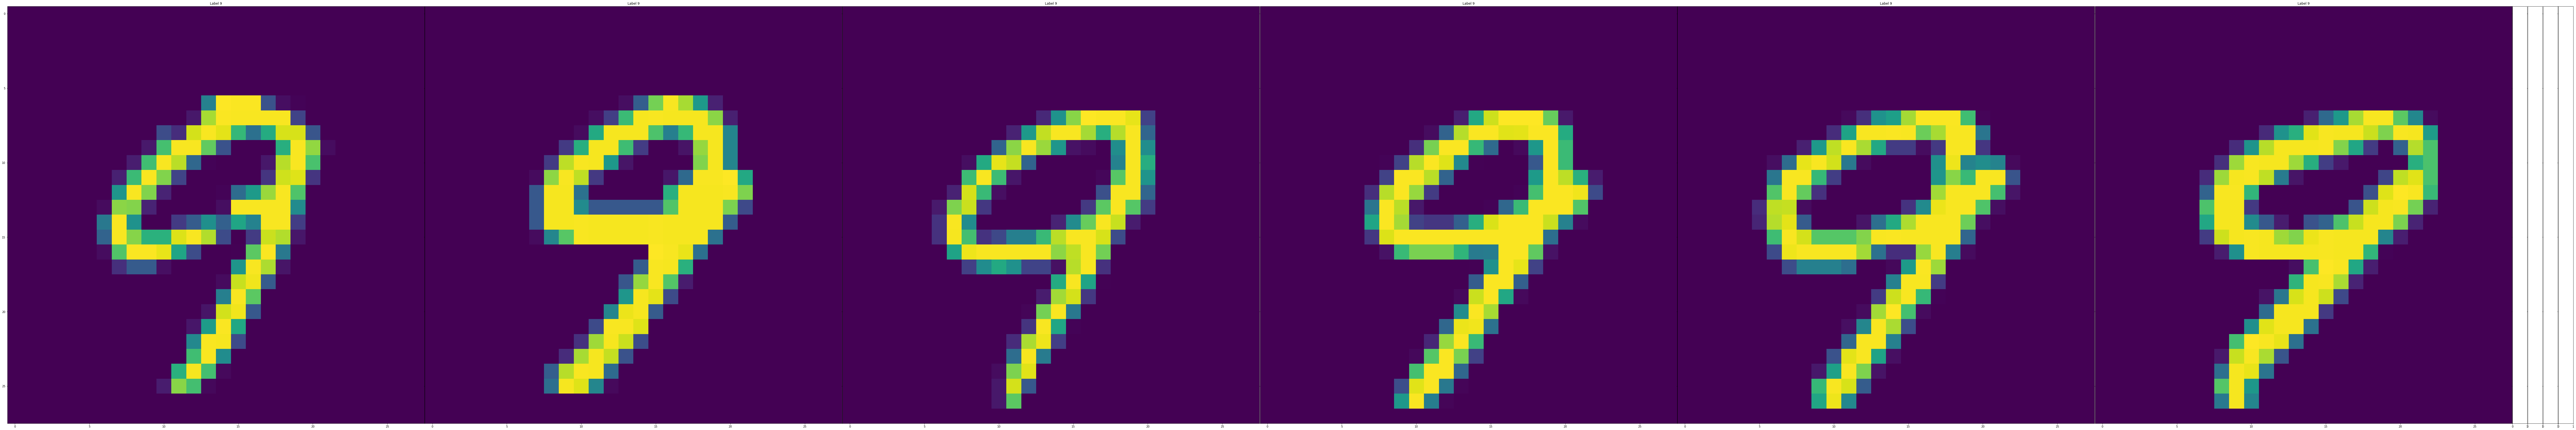

Cluster  46, size: 9


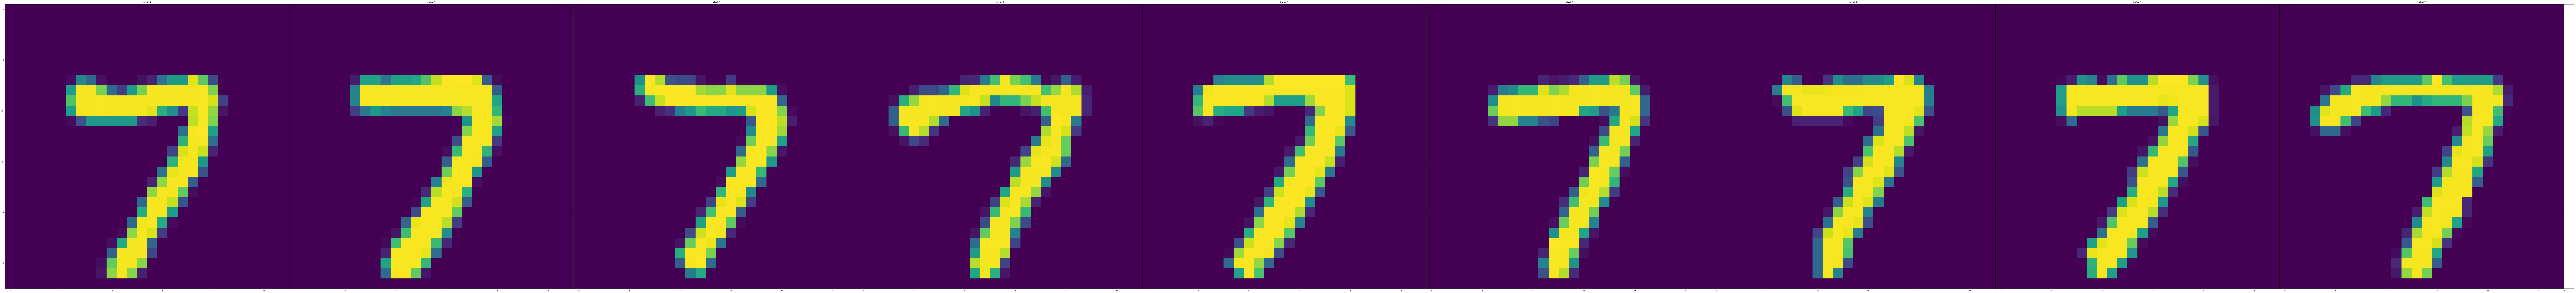

Cluster  39, size: 8


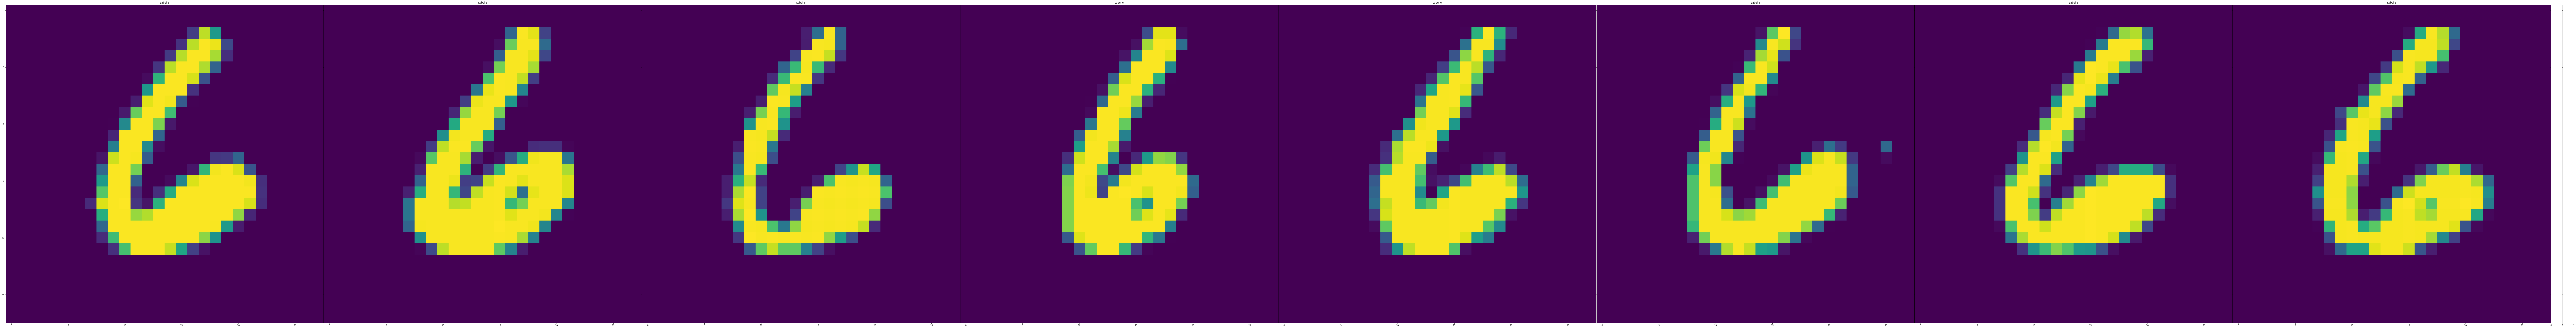

Cluster  9, size: 12


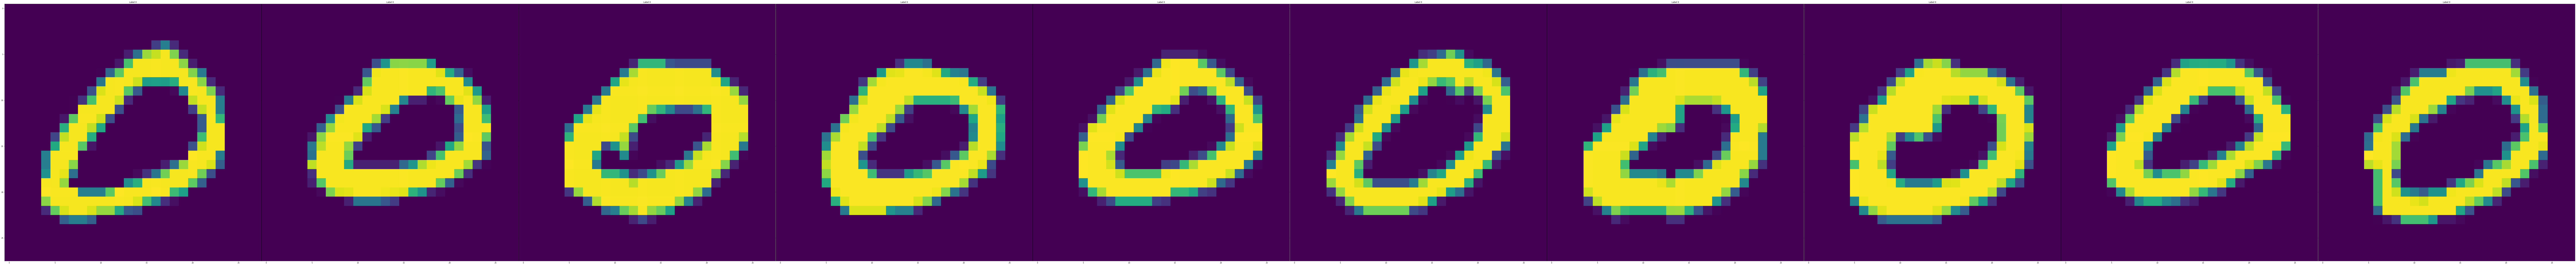

Cluster  4, size: 8


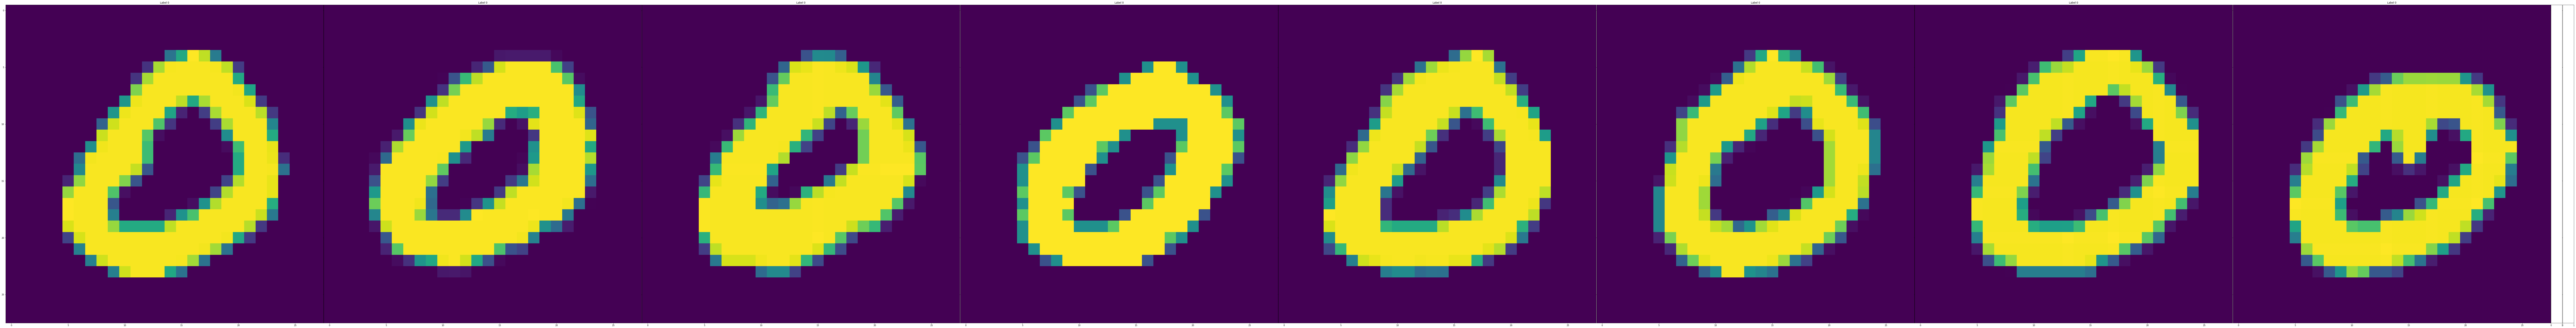

Cluster  2, size: 7


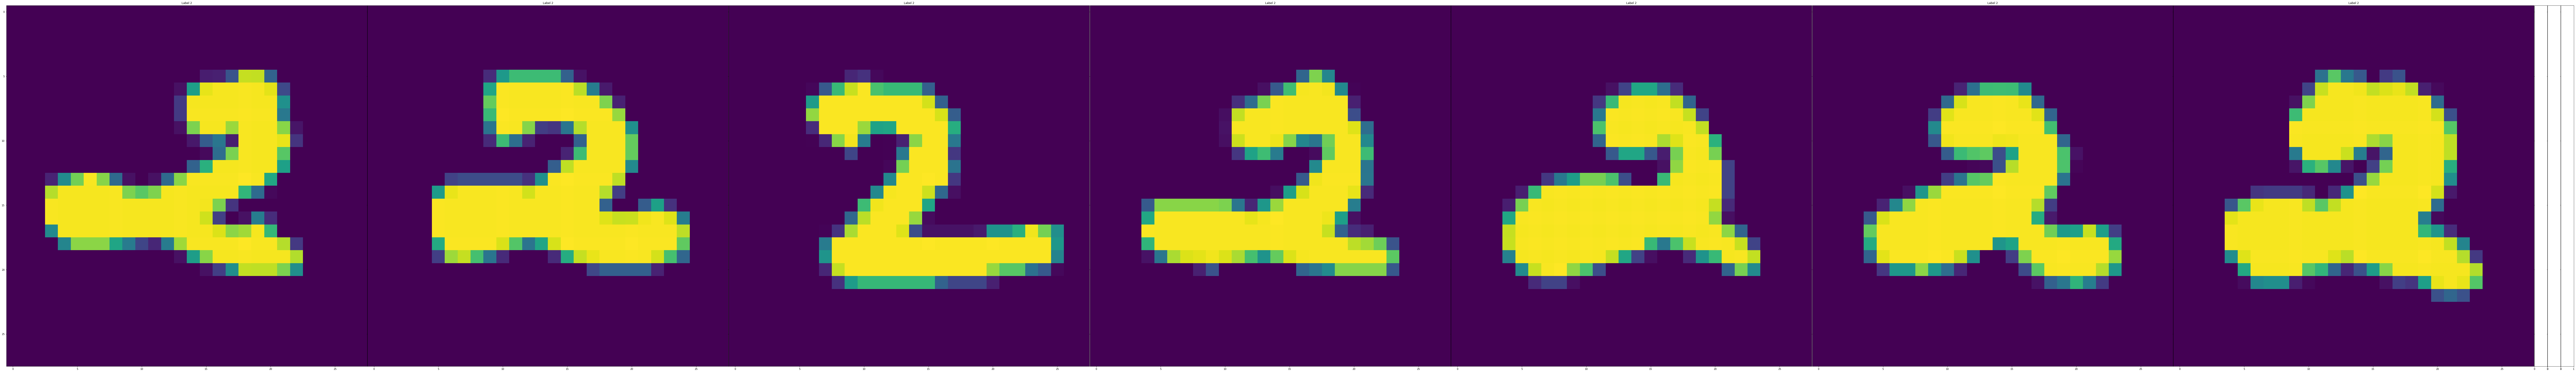

Cluster  7, size: 5


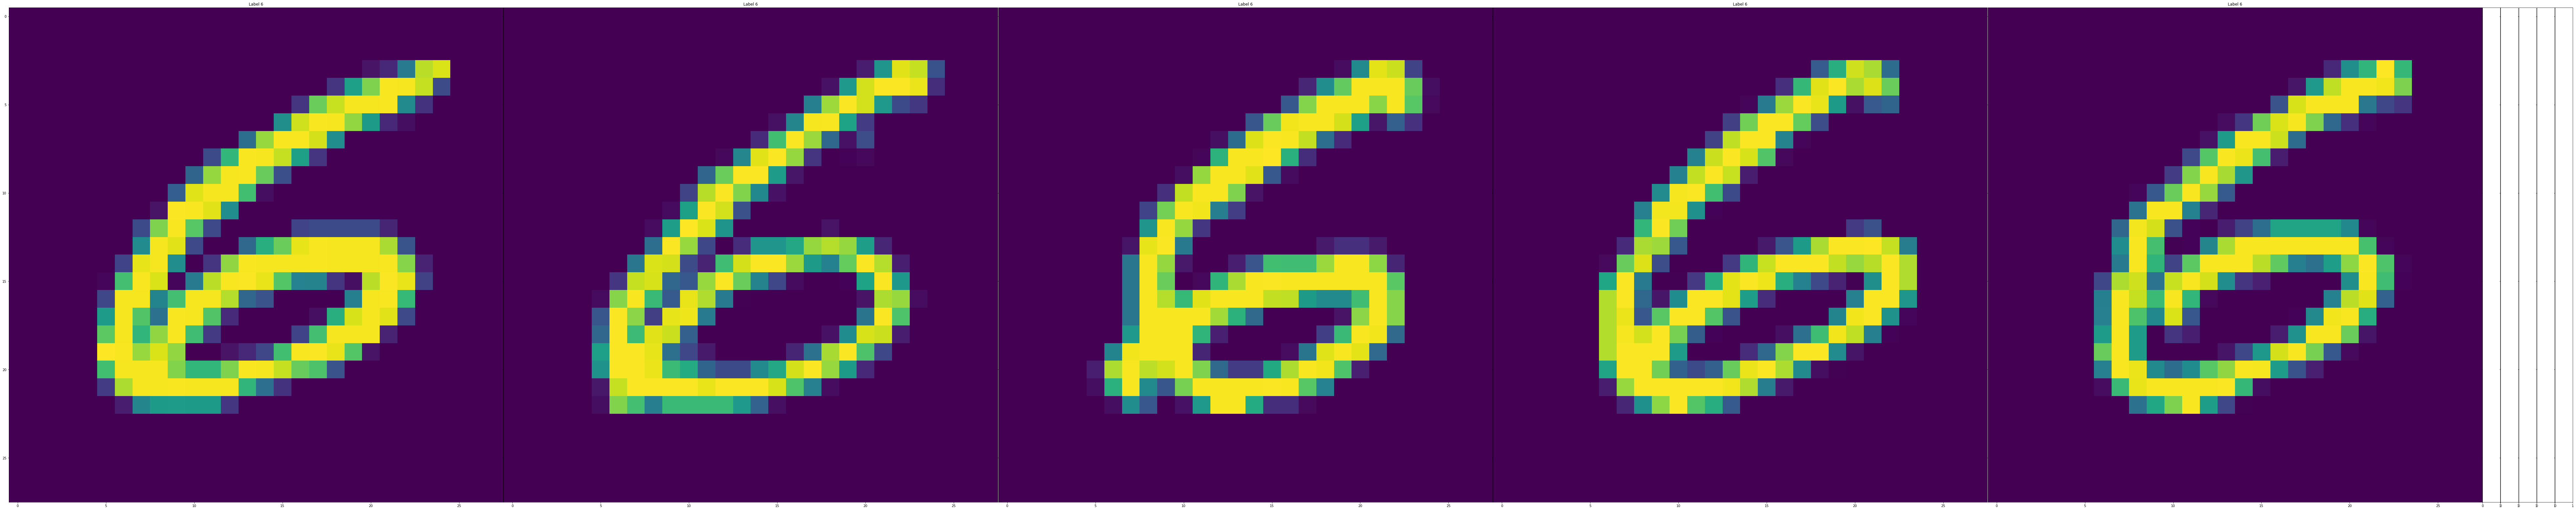

Cluster  31, size: 8


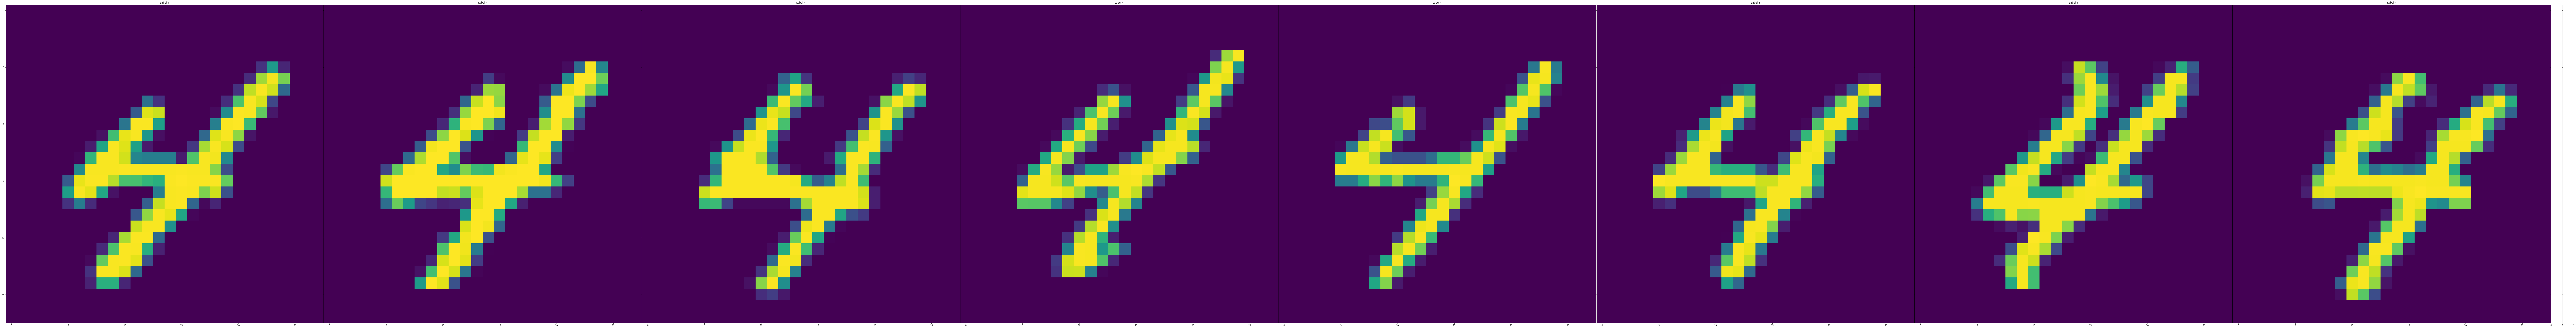

Cluster  11, size: 7


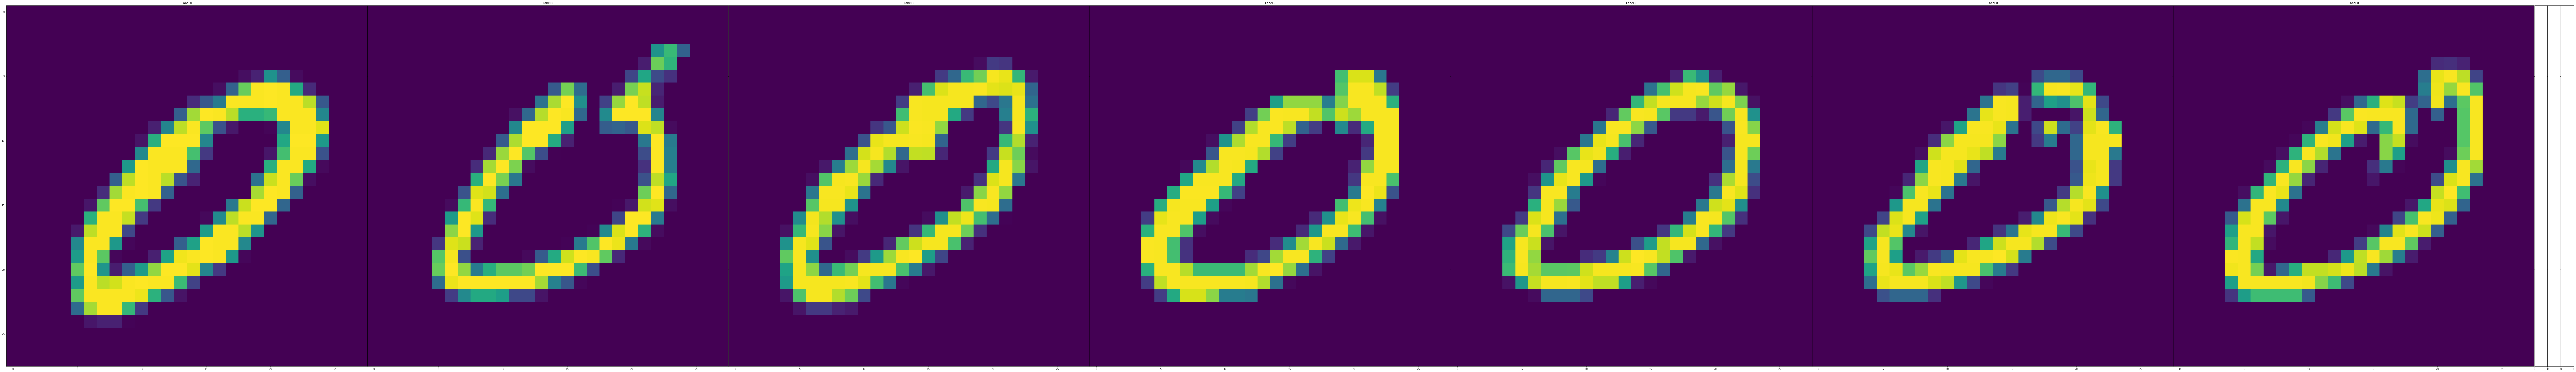

Cluster  42, size: 5


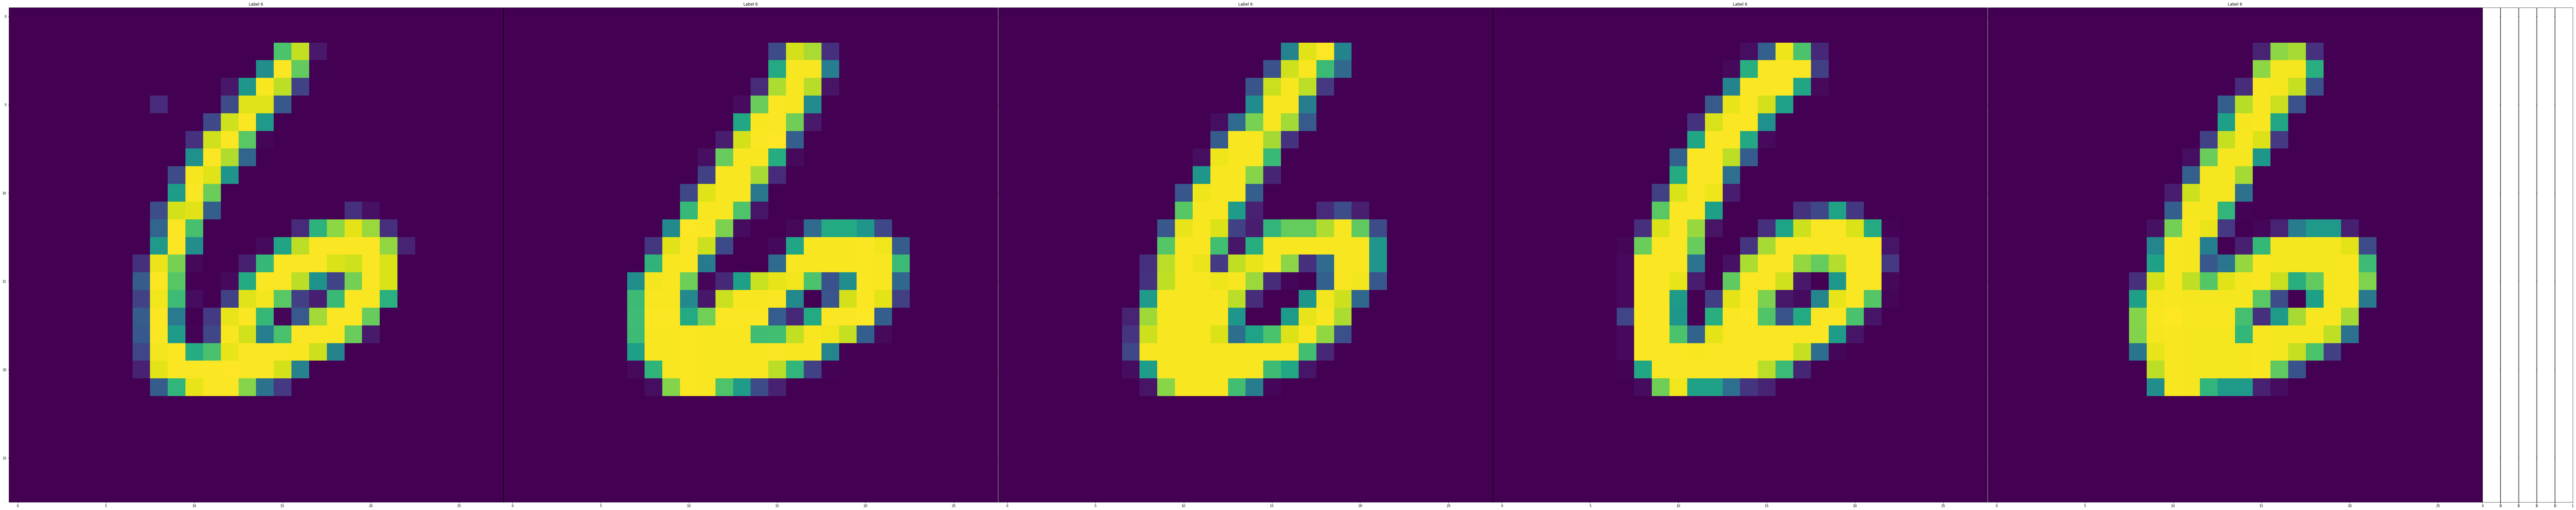

Cluster  13, size: 8


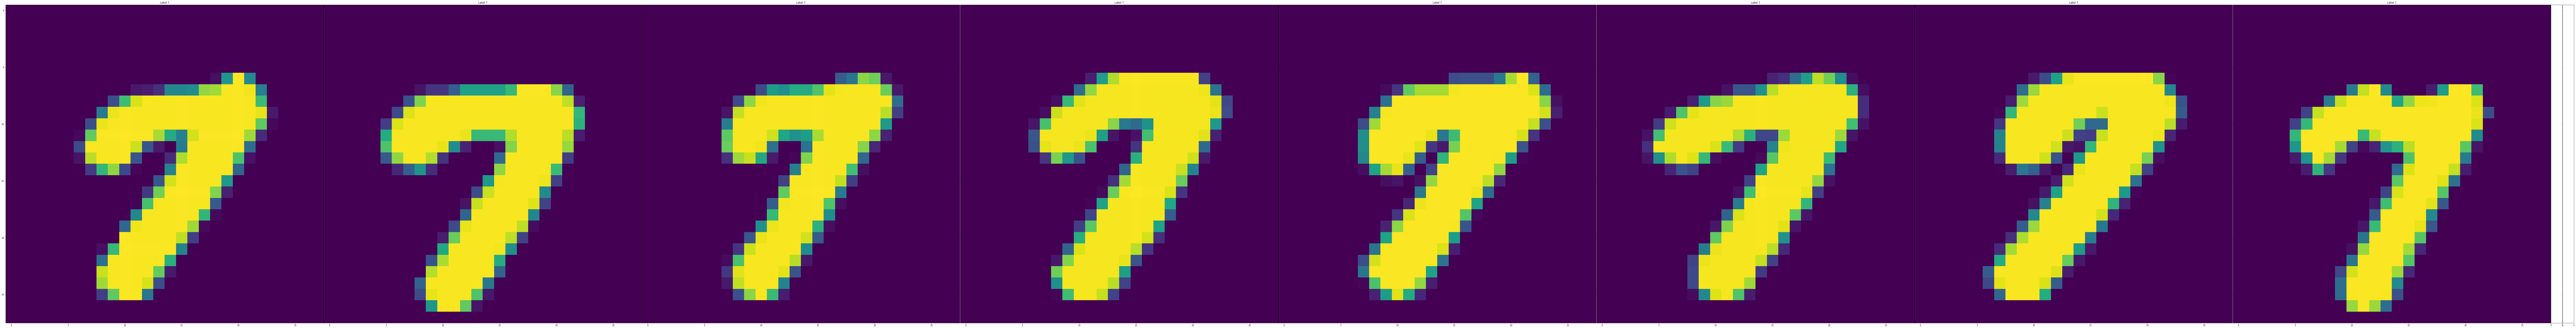

Cluster  44, size: 8


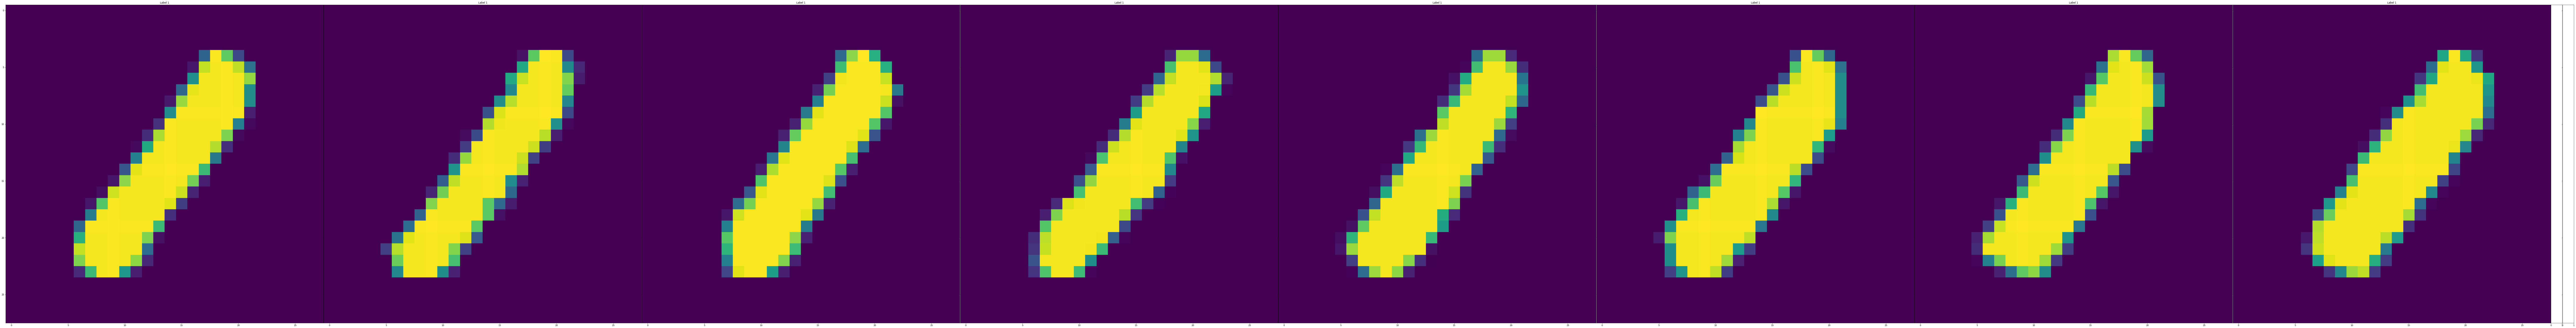

In [54]:
import random
nSamples = 10
images_per_row = 10
imSize = x_test[0].shape[1]
from mpl_toolkits.axes_grid1 import ImageGrid
for cluster in clusters.clusterId.unique():
    cluster_size = clusters[clusters['clusterId'] == cluster].shape[0]
    sampleSize = min(cluster_size, nSamples)
    f_others = clusters[clusters['clusterId'] == cluster].sample(sampleSize)
    
    nRows =  max(1, sampleSize / images_per_row)
    
    fig = plt.figure(figsize=(min(images_per_row, sampleSize)*imSize, nRows*imSize))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(nRows, images_per_row),  # creates 2x2 grid of axes
                 )
    for ax, im in zip(grid, f_others.iterrows()):
        ax.imshow(x_test[im[0]])
        ax.set_title(F'Label {y_test_l[im[0]]}')
    print(F"Cluster  {cluster}, size: {cluster_size}")
    plt.title(label = F"Cluster  {cluster}")
    plt.grid(False)
    plt.show()
    #fig = px.imshow(np.array(img_sequence, facet_col=0, binary_string=True, title=F"Cluster {cluster}")
    #fig.show() 
    #break
#random.choice(list(enumerate(clusterer.labels_)))